<a href="https://colab.research.google.com/github/suebatista/hackathon/blob/main/dermatite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DATATHON - DERMATITE ATÓPICA**#
Eretz.bio / Hospital Albert Einstein / Apoio: Abbvie <br>

**Grupo de trabalho:**<br>
DataDES

**Integrantes:** <br>
Danilo Gouvea Silva<br>
Eduardo R. Malaquias Chagas<br>
Suelen Cristina Batista da Silva


##**PREPARAÇÃO DO NOTEBOOK E IMPORTAÇÃO DOS DATASETS**##

In [1]:
# Import libraries
from google.colab import files
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import graphing libraries
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Import data sets from Google Drive
# This only needs to be done once per notebook session

# '/datathon-dermatite/data/' Google Drive folder id 
data_id = '1TNeTdeTIez7hZZwOc0WsewaD_n3vzoGx'

# List folders under '/datathon-dermatite/data/'
folders = drive.ListFile({'q': "mimeType contains '.folder' and '{}' in parents".format(data_id)}).GetList()
for folder in folders:
    Path.mkdir(Path() / 'data' / folder['title'], parents=True, exist_ok=True)
    files = drive.ListFile({'q': "title contains '.parquet' and '{}' in parents".format(folder['id'])}).GetList()
    for fn in files:
        # Download file
        fn_id = fn['id']
        fn_title = fn['title']
        downloaded = drive.CreateFile({'id': fn_id, 'title': fn_title})
        downloaded.GetContentFile(fn_title)

        # Move file to right folder
        filepath = Path().cwd() / fn_title
        Path(filepath).rename(Path().cwd() / 'data' / folder['title'] / fn_title)

        # Success message
        print(f'"{fn_title}" successfully imported to "./data/{folder["title"]}"')
  
# Success message
print('ALL FILES IMPORTED!')


"part-00001-c4fb50db-777b-4088-a8c1-a6d07675ee92-c000.snappy.parquet" successfully imported to "./data/tb_sigtap_procedimento"
"part-00002-c4fb50db-777b-4088-a8c1-a6d07675ee92-c000.snappy.parquet" successfully imported to "./data/tb_sigtap_procedimento"
"part-00000-c4fb50db-777b-4088-a8c1-a6d07675ee92-c000.snappy.parquet" successfully imported to "./data/tb_sigtap_procedimento"
"part-00000-58b508dc-6dbc-4fbf-a365-09d87bf87110-c000.snappy.parquet" successfully imported to "./data/tb_sigtap_cid"
"part-00000-bb98e2d2-70a5-4a53-8f52-35825886edcb-c000.snappy.parquet" successfully imported to "./data/tb_ibge_uf"
"part-00000-06e61d69-5c00-4679-9e81-3dfc062ef50d-c000.snappy.parquet" successfully imported to "./data/tb_ibge_municipio"
"part-00001-b77ee803-92a5-463f-ab53-d2f7da4b2dce-c000.snappy.parquet" successfully imported to "./data/tb_cnes_estabelecimentos"
"part-00000-b77ee803-92a5-463f-ab53-d2f7da4b2dce-c000.snappy.parquet" successfully imported to "./data/tb_cnes_estabelecimentos"
"INSS_

##**ANÁLISE EXPLORATÓRIA**##

In [4]:
# Dicionário de estados  
UF = { 
    # NORTE 
    '11': 'RO',
    '12': 'AC',
    '13': 'AM',
    '14': 'RR',
    '15': 'PA',
    '16': 'AP',
    '17': 'TO',
    
    # NORDESTE
    '21': 'MA',
    '22': 'PI',
    '23': 'CE',
    '24': 'RN',
    '25': 'PB',
    '26': 'PE',
    '27': 'AL',
    '28': 'SE',
    '29': 'BA',
     
    # SUDESTE 
    '31': 'MG',
    '32': 'ES',
    '33': 'RJ',
    '35': 'SP',

    # SUL
    '41': 'PR',
    '42': 'SC',
    '43': 'RS',

    # CENTRO OESTE
    '50': 'MS',
    '51': 'MT',
    '52': 'GO',
    '53': 'DF'
} 

###TB_CNES_ESTABELECIMENTOS###
Tabela auxiliar que contém informações sobre os estabelecimentos de saúde

In [5]:
# Create dataframe
folder_path = Path('data/tb_cnes_estabelecimentos')
df_cnes = pd.read_parquet(folder_path, engine='pyarrow')

In [6]:
df_cnes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418045 entries, 0 to 418044
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   CO_UNIDADE                   418045 non-null  object
 1   CO_CNES                      418045 non-null  object
 2   NU_CNPJ_MANTENEDORA          101945 non-null  object
 3   TP_PFPJ                      418045 non-null  object
 4   NIVEL_DEP                    418045 non-null  object
 5   NO_RAZAO_SOCIAL              418043 non-null  object
 6   NO_FANTASIA                  418023 non-null  object
 7   NO_LOGRADOURO                418044 non-null  object
 8   NU_ENDERECO                  417756 non-null  object
 9   NO_COMPLEMENTO               187219 non-null  object
 10  NO_BAIRRO                    418043 non-null  object
 11  CO_CEP                       418045 non-null  object
 12  CO_REGIAO_SAUDE              209513 non-null  object
 13  CO_MICRO_REGIA

In [7]:
# Values dictionary extracted from http://cnes2.datasus.gov.br/Mod_Ind_Unidade_Novo.asp?VEstado=00

tipo_unidade = {
    '01': 'POSTO DE SAUDE',
    '02': 'CENTRO DE SAUDE/UNIDADE BASICA',
    '04': 'POLICLINICA',
    '05': 'HOSPITAL GERAL',
    '07': 'HOSPITAL ESPECIALIZADO',
    '15': 'UNIDADE MISTA',
    '20': 'PRONTO SOCORRO GERAL',
    '21': 'PRONTO SOCORRO ESPECIALIZADO',
    '22': 'CONSULTORIO ISOLADO',
    '32': 'UNIDADE MOVEL FLUVIAL',
    '36': 'CLINICA/CENTRO DE ESPECIALIDADE',
    '39': 'UNIDADE DE APOIO DIAGNOSE E TERAPIA (SADT ISOLADO)',
    '40': 'UNIDADE MOVEL TERRESTRE',
    '42': 'UNIDADE MOVEL DE NIVEL PRE-HOSPITALAR NA AREA DE URGENCIA',
    '43': 'FARMACIA',
    '50': 'UNIDADE DE VIGILANCIA EM SAUDE',
    '60': 'COOPERATIVA OU EMPRESA DE CESSAO DE TRABALHADORES NA SAUDE',
    '61': 'CENTRO DE PARTO NORMAL - ISOLADO',
    '62': 'HOSPITAL/DIA - ISOLADO',
    '64': 'CENTRAL DE REGULACAO DE SERVICOS DE SAUDE',
    '67': 'LABORATORIO CENTRAL DE SAUDE PUBLICA LACEN',
    '68': 'CENTRAL DE GESTAO EM SAUDE',
    '69': 'CENTRO DE ATENCAO HEMOTERAPIA E OU HEMATOLOGICA',
    '70': 'CENTRO DE ATENCAO PSICOSSOCIAL',
    '71': 'CENTRO DE APOIO A SAUDE DA FAMILIA',
    '72': 'UNIDADE DE ATENCAO A SAUDE INDIGENA',
    '73': 'PRONTO ATENDIMENTO',
    '74': 'POLO ACADEMIA DA SAUDE',
    '75': 'TELESSAUDE',
    '76': 'CENTRAL DE REGULACAO MEDICA DAS URGENCIAS',
    '77': 'SERVICO DE ATENCAO DOMICILIAR ISOLADO(HOME CARE)',
    '78': 'UNIDADE DE ATENCAO EM REGIME RESIDENCIAL',
    '79': 'OFICINA ORTOPEDICA',
    '80': 'LABORATORIO DE SAUDE PUBLICA',
    '81': 'CENTRAL DE REGULACAO DO ACESSO',
    '82': 'CENTRAL DE NOTIFICACAO,CAPTACAO E DISTRIB DE ORGAOS ESTADUAL',
    '83': 'POLO DE PREVENCAO DE DOENCAS E AGRAVOS E PROMOCAO DA SAUDE',
    '84': 'CENTRAL DE ABASTECIMENTO',
    '85': 'CENTRO DE IMUNIZAÇÃO'
}

df_tipo_unidade = pd.DataFrame({'NO_TP_UNIDADE': tipo_unidade.values()}, index=tipo_unidade.keys())

emergency_cnes_types = df_tipo_unidade[(df_tipo_unidade.NO_TP_UNIDADE.str.contains('PRONTO')) | \
                                     (df_tipo_unidade.NO_TP_UNIDADE.str.contains('URGENCIA'))].index

# To be used to define severity later on
emergency_cnes_types


Index(['20', '21', '42', '73', '76'], dtype='object')

In [8]:
# Check which 'Tipo de Estabelecimento' are most common in the data base.
df_cnes.TP_UNIDADE.value_counts().to_frame().head(20).join(df_tipo_unidade)

,TP_UNIDADE,NO_TP_UNIDADE
22,207430,CONSULTORIO ISOLADO
36,64022,CLINICA/CENTRO DE ESPECIALIDADE
02,41133,CENTRO DE SAUDE/UNIDADE BASICA
39,31623,UNIDADE DE APOIO DIAGNOSE E TERAPIA (SADT ISOL...
01,11850,POSTO DE SAUDE
04,11311,POLICLINICA
43,6343,FARMACIA
05,6254,HOSPITAL GERAL
68,6176,CENTRAL DE GESTAO EM SAUDE
42,5364,UNIDADE MOVEL DE NIVEL PRE-HOSPITALAR NA AREA ...


In [9]:
# https://datasus.saude.gov.br/transferencia-de-arquivos/
# Extracted from TB_CNES.zip downloaded from 'Arquivos auxiliares para tabulação / Arquivos de definição do Tabwin
# File: TAB_CNES/CNV/TP_GESTAO.CNV
tipo_gestao = {
    'D': 'DUPLA',
    'E': 'ESTADUAL',
    'M': 'MUNICIPAL',
    'S': 'SEM GESTÃO'
}


In [10]:
# Create columns
df_cnes['NO_UNIDADE'] = df_cnes.TP_UNIDADE.map(tipo_unidade)
df_cnes['NO_GESTAO'] = df_cnes.TP_GESTAO.map(tipo_gestao)

In [11]:
# Selected columns for final data frame
cnes_columns = ['CO_UNIDADE',
                'CO_CNES',
                'NO_FANTASIA',
                'TP_UNIDADE',
                'NO_UNIDADE', # CRIADA
                'NU_LATITUDE',
                'NU_LONGITUDE',
                'TP_GESTAO',
                'NO_GESTAO',  # CRIADA
                'CO_ATIVIDADE_PRINCIPAL']

In [12]:
df_cnes = df_cnes[cnes_columns]
df_cnes.head(2)

,CO_UNIDADE,CO_CNES,NO_FANTASIA,TP_UNIDADE,NO_UNIDADE,NU_LATITUDE,NU_LONGITUDE,TP_GESTAO,NO_GESTAO,CO_ATIVIDADE_PRINCIPAL
0,3556205173388,5173388,SILVIO MAURICIO RINHEL VIRDES,22,CONSULTORIO ISOLADO,-22.9722215,-46.9953355,M,MUNICIPAL,001
1,4306102263483,2263483,LABORATORIO BISSO LTDA,39,UNIDADE DE APOIO DIAGNOSE E TERAPIA (SADT ISOL...,-28.637791,-53.6143623,M,MUNICIPAL,002


###TB_SIGTAP_CID###
Tabela auxiliar que contém os códigos CID10 e descrições

In [13]:
# Create dataframe
folder_path = Path('data/tb_sigtap_cid')
df_cid = pd.read_parquet(folder_path, engine='pyarrow')

In [14]:
# df_cid.set_index('CO_CID', inplace=True)

In [15]:
df_cid.head()

,CO_CID,NO_CID,TP_AGRAVO,TP_SEXO,TP_ESTADIO,VL_CAMPOS_IRRADIADOS
0,A00,Cólera,0,I,N,000
1,A000,"Cólera devida a Vibrio Cholerae 01, biótipo Ch...",2,I,N,000
2,A001,"Cólera devida a Vibrio Cholerae 01, biótipo El...",2,I,N,000
3,A009,Cólera não especificada,2,I,N,000
4,A01,Febres tifóide e paratifóide,0,I,N,000


In [16]:
# Create a data frame containing only 3 digit CID10 codes and their descriptions
cids = {}
for row in df_cid.itertuples():
  cid = row.CO_CID[:3]
  if not cid in cids:
    cids[cid] = row.NO_CID

df_cid_short = pd.DataFrame({'NO_CID': cids.values()}, index=cids.keys())
df_cid_short

,NO_CID
A00,Cólera
A01,Febres tifóide e paratifóide
A02,Outras infecções por Salmonella
A03,Shiguelose
A04,Outras infecções intestinais bactérianas
...,...
Z95,Presenca de implantes e enxertos cardiacos e v...
Z96,Outros implantes funcionais
Z97,Presenca de outros dispositivos protéticos
Z98,Presenca de outros estados pós-cirurgicos


###TB_SIGTAP_PROCEDIMENTO###
Tabela auxiliar que contém códigos de procedimentos e descrições.

A base de dados original possui diversos registros para o mesmo código e descrição de procedimento. A sequência de scripts abaixo cria um data frame com um registro único por código de procedimento e descrição.

In [17]:
# Create dataframe
folder_path = Path('data/tb_sigtap_procedimento')
df_sigtap = pd.read_parquet(folder_path, engine='pyarrow')

In [18]:
# Check data frame info
df_sigtap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275577 entries, 0 to 275576
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CO_PROCEDIMENTO       275577 non-null  object
 1   NO_PROCEDIMENTO       275577 non-null  object
 2   TP_COMPLEXIDADE       275577 non-null  object
 3   TP_SEXO               275577 non-null  object
 4   QT_MAXIMA_EXECUCAO    275577 non-null  object
 5   QT_DIAS_PERMANENCIA   275577 non-null  object
 6   QT_PONTOS             275577 non-null  object
 7   VL_IDADE_MINIMA       275577 non-null  object
 8   VL_IDADE_MAXIMA       275577 non-null  object
 9   VL_SH                 275577 non-null  object
 10  VL_SA                 275577 non-null  object
 11  VL_SP                 275577 non-null  object
 12  CO_FINANCIAMENTO      275577 non-null  object
 13  CO_RUBRICA            21837 non-null   object
 14  QT_TEMPO_PERMANENCIA  275577 non-null  object
 15  DT_COMPETENCIA   

In [19]:
# Check number of unique 'CÓDIGO PROCEDIMENTO'
df_sigtap.CO_PROCEDIMENTO.nunique()

4783

In [20]:
# Create a new data frame with only one register per CO_PROCEDIMENTO
procedures = {}
for row in df_sigtap.itertuples():
    if not row.CO_PROCEDIMENTO in procedures:
        procedures[row.CO_PROCEDIMENTO] = row.NO_PROCEDIMENTO
        
df_proc = pd.DataFrame({'CO_PROCEDIMENTO': procedures.keys(), 'NO_PROCEDIMENTO': procedures.values()})

In [21]:
df_proc.set_index('CO_PROCEDIMENTO', inplace=True)

In [22]:
# Phototherapy codes
df_phototherapy = df_proc[df_proc.NO_PROCEDIMENTO.str.contains('FOTOTERAPIA')]
df_phototherapy

,NO_PROCEDIMENTO
CO_PROCEDIMENTO,
0303080108,FOTOTERAPIA (POR SESSÃO)
0303080116,FOTOTERAPIA COM FOTOSSENSIBILIZAÇÃO (POR SESSÃO)


In [23]:
# Emergency procedures
emergency_procedures = df_proc[        
                              (df_proc.NO_PROCEDIMENTO.str.contains('URGÊNCIA')) | \
                              (df_proc.NO_PROCEDIMENTO.str.contains('PRONTO')) | \
                              (df_proc.NO_PROCEDIMENTO.str.contains('URGENCIA'))
].index

# To be used to determine severity later on
emergency_procedures


Index(['0301030014', '0301030111', '0301030146', '0301060010', '0301060029',
       '0301060037', '0301060045', '0301060053', '0301060061', '0301060070',
       '0301060088', '0301060096', '0301080399', '0413010015', '0413010023',
       '0603050115', '0603050123'],
      dtype='object', name='CO_PROCEDIMENTO')

In [24]:
# Medication for L20 according to Eretz.bio presentation

med_selection = (df_proc.NO_PROCEDIMENTO.str.contains('DEXAMETASONA')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('CLOBETASOL')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('TACROLIMO')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('PIMECROLIMO')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('METOTREXATO')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('CICLOSPORINA')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('AZATIOPRINA')) | \
                (df_proc.NO_PROCEDIMENTO.str.contains('MOFETILA'))

df_medication = df_proc[med_selection]
# df_medication

# To be used later on to determine severity
ciclosporina = df_proc[df_proc.NO_PROCEDIMENTO.str.contains('CICLOSPORINA')].index
ciclosporina


Index(['0202070182', '0501080031', '0603020011', '0603020020', '0603020038',
       '0603020046', '0603020054', '0603080022', '0603080030', '0603080049',
       '0603080057', '0604340010', '0604340028', '0604340036', '0604340044',
       '0604340052'],
      dtype='object', name='CO_PROCEDIMENTO')

As proporções de utilização de procedimento de FOTOTERAPIA foram calculadas localmente utilizando a base de dados 'tb_sia_pa' completa, contendo todos os códigos CID10.

Não há na base de dados completa **nenhum registro** de utilização do procedimento de FOTOTERAPIA com código CID primário ou secundário da DERMATITE ATÓPICA (L20).

In [25]:
# Proportion of PHOTOTHERAPY procedures
df_pt = pd.DataFrame({'CID': ['L40', 'L80', 'C84', 'L86'],
                      'COUNT': [243404, 158888, 142826, 59592],
                      'PERCENT': [40.3, 26.3, 23.6, 9.9]})

df_pt.join(df_cid_short, on='CID')

,CID,COUNT,PERCENT,NO_CID
0,L40,243404,40.3,Psoríase
1,L80,158888,26.3,Vitiligo
2,C84,142826,23.6,Linfomas de células t cutâneas e periféricas
3,L86,59592,9.9,Ceratodermia em doenças classificadas em outra...


In [26]:
# Deaseases treated with PHOTOTHERAPY according to database 'tb_sia_pa'
phototherapy = {
    'L40': 'psoríase',
    'L80': 'vitiligo',
    'C84': 'Linfomas de células t cutâneas e periféricas',   # Não está nas bases do Google Drive - Micose fungoide é um sub-grupo.
    'L86': 'ceratodermia em doenças classificadas em outra parte'
}

###TB_SIA_PA###
Base de dados principal

Sistema de Informações Ambulatoriais do SUS
PA – Produção Ambulatorial.

A base carregada no Google Drive foi filtrada localmente e contém somente os registros de doenças de pele (CID-10 grupo XII, Lxxx) como causas primária ou secundárias.

In [27]:
# Create dataframe
folder_path = Path() / 'data' / 'tb_sia_pa'
df_sia = pd.read_parquet(folder_path, engine='pyarrow')

In [28]:
df_sia.shape

(5324351, 60)

In [29]:
df_sia.head()

,PA_CODUNI,PA_GESTAO,PA_CONDIC,PA_UFMUN,PA_REGCT,PA_INCOUT,PA_INCURG,PA_TPUPS,PA_TIPPRE,PA_MN_IND,PA_CNPJCPF,PA_CNPJMNT,PA_CNPJ_CC,PA_MVM,PA_CMP,PA_PROC_ID,PA_TPFIN,PA_SUBFIN,PA_NIVCPL,PA_DOCORIG,PA_AUTORIZ,PA_CNSMED,PA_CBOCOD,PA_MOTSAI,PA_OBITO,PA_ENCERR,PA_PERMAN,PA_ALTA,PA_TRANSF,PA_CIDPRI,PA_CIDSEC,PA_CIDCAS,PA_CATEND,PA_IDADE,IDADEMIN,IDADEMAX,PA_FLIDADE,PA_SEXO,PA_RACACOR,PA_MUNPCN,PA_QTDPRO,PA_QTDAPR,PA_VALPRO,PA_VALAPR,PA_UFDIF,PA_MNDIF,PA_DIF_VAL,NU_VPA_TOT,NU_PA_TOT,PA_INDICA,PA_CODOCO,PA_FLQT,PA_FLER,PA_ETNIA,PA_VL_CF,PA_VL_CL,PA_VL_INC,PA_SRV_C,PA_INE,PA_NAT_JUR
0,2719991,270000,EP,270430,0000,0000,0000,43,00,M,12200259000165,12200259000165,00000000000000,201605,201605,0604600020,02,0000,3,P,2716200188878,000000000000000,223405,21,0,0,1,0,0,L404,0000,0000,01,048,0,130,1,F,03,270430,30,30,159.3,159.3,0,0,0.0,0.0,5.31,5,1,K,0,None,0.0,0.0,0.0,125001,None,1023
1,2719991,270000,EP,270430,0000,0000,0000,43,00,M,12200259000165,12200259000165,00000000000000,201605,201605,0604590024,02,0000,3,P,2716200192024,000000000000000,223405,21,0,0,1,0,0,L700,0000,0000,01,024,0,130,1,M,03,270915,60,60,0.0,0.0,0,1,0.0,0.0,0.0,5,1,K,0,None,0.0,0.0,0.0,125001,None,1023
2,2719991,270000,EP,270430,0000,0000,0000,43,00,M,12200259000165,12200259000165,00000000000000,201605,201605,0604590024,02,0000,3,P,2716200192035,000000000000000,223405,21,0,0,1,0,0,L700,0000,0000,01,027,0,130,1,F,03,270915,60,60,0.0,0.0,0,1,0.0,0.0,0.0,5,1,K,0,None,0.0,0.0,0.0,125001,None,1023
3,2719991,270000,EP,270430,0000,0000,0000,43,00,M,12200259000165,12200259000165,00000000000000,201605,201605,0604590024,02,0000,3,P,2716200193840,000000000000000,223405,21,0,0,1,0,0,L700,0000,0000,01,034,0,130,1,M,01,270430,120,120,0.0,0.0,0,0,0.0,0.0,0.0,5,1,K,0,None,0.0,0.0,0.0,125001,None,1023
4,2719991,270000,EP,270430,0000,0000,0000,43,00,M,12200259000165,12200259000165,00000000000000,201605,201605,0604590024,02,0000,3,P,2716200178802,000000000000000,223405,21,0,0,1,0,0,L700,0000,0000,01,016,0,130,1,F,99,270430,60,60,0.0,0.0,0,0,0.0,0.0,0.0,5,1,K,0,None,0.0,0.0,0.0,125001,None,1023


In [30]:
# Documento de origem dict
pa_docorig = {
    'P': 'APAC-P',  # Autorização de Procedimento Ambulatoria de Alta Complexidade - Procedimento Principal
    'S': 'APAC-S',  # Autorização de Procedimento Ambulatoria de Alta Complexidade - Procedimento Secundário
    'C': 'BPA-C',  # Boletim de Produção Ambulatorial Consolidado
    'I': 'BPA-I',  # Boletim de Produção Ambulatorial Individualizado
    'A': 'RAAS-AD',  # Registro das Ações Ambulatoriais de Saúde - Atenção Domiciliar
    'B': 'RAAS_PSI'  # Registro das Ações Ambulatoriais de Saúde - Psicossocial
}

In [31]:
# Create columns
df_sia['UF'] = df_sia.PA_UFMUN.str[:2]
df_sia['UF'] = df_sia.UF.map(UF)

df_sia['ANO'] = df_sia.PA_MVM.str[:4]
df_sia['MES'] = df_sia.PA_MVM.str[4:]
df_sia['DOC'] = df_sia.PA_DOCORIG.map(pa_docorig)
df_sia['SEVERIDADE'] = np.nan  # Coluna vazia por enquanto. Depois será necessário definir critérios de severidade e identificar cada registro

In [32]:
sia_mask_columns = ['PA_CODUNI',  # SCNES do estabelecimentos de saúde
                    # 'PA_GESTAO',  # UF + Município do gestor (não é localidade do estabelecimento)
                    'SEVERIDADE',  # Severidade do caso  // CRIADA
                    'PA_UFMUN',  # UF + Município do estabelecimento
                    'UF',  # UF do estabelcimento  // CRIADA
                    'PA_TPUPS',  # Tipo de estabelecimento
                    'PA_MVM',  # Data de processamento/movimento  // ESCOLHER ESSA DATA
                    # 'PA_CMP',  #  Data de realização do procedimento
                    'ANO',  # Ano  // CRIADA
                    'MES',  # Mês  // CRIADA
                    'PA_PROC_ID', # Código de procedimento ambulatorial
                    'PA_DOCORIG',  # Instrumento de registro (APAC / BPA / RAAS)
                    'DOC',  # Tipo de documento  // CRIADA
                    'PA_AUTORIZ',  # Número da APAC ou número de autorização do BPA-I. Não obrigatório no BPA-I
                    'PA_CIDPRI',  # CID Principal (APAC ou BPA-I)
                    'PA_CIDSEC',  # CID Secundário (APAC)
                    'PA_CIDCAS',  # CID Causas Associadas (APAC)
                    # 'PA_CATEND',  # Caráter de atendimento // ???
                    'PA_IDADE',  # Idade do paciente em anos
                    'PA_SEXO',  # Sexo do paciente
                    'PA_RACACOR',  # Raça/cor do paciente
                    'PA_MUNPCN',  # UF + Município de residência do paciente. Para BPA, referente ao estabelecimento
                    # 'PA_QTDPRO',  # Quantidade apresentada
                    'PA_QTDAPR',  # Quantidade aprovada
                    # 'PA_VALPRO',  # Valor apresentado
                    'PA_VALAPR',  # Valor aprovado TOTAL (PA_QTDAPR * NU_PA_TOT)
                    # 'NU_VPA_TOT', # Valor Unitário do Procedimento da Tabela VPA // Unitário  // Quando não zerado é igual à 'NU_PA_TOT'
                    'NU_PA_TOT']  # Valor Unitário do Procedimento da Tabela SIGTAP // Unitário
                    # 'PA_INDICA']  # Indicativo: 0 = não aprovado, 5 = aprovado total, 6 = aprovado parcial  // Não relevante
                    # 'PA_CODOCO']  # Código de ocorrência // ???

In [33]:
# Check number of 'L20' (DA) items per column

cid_sia_columns = ['PA_CIDPRI', 'PA_CIDSEC', 'PA_CIDCAS']

d = {}
for column in cid_sia_columns:
    s = df_sia[column].str[:3] == 'L20'
    s = s.agg('sum')
    d[column] = [s]

pd.DataFrame.from_dict(d)

,PA_CIDPRI,PA_CIDSEC,PA_CIDCAS
0,46150,1,47


Qual é a proporção da incidência de Dermatite Atópica em comparação com outras doenças de pele na base SIA de produção ambulatorial?

**R: Dermatite atópica representa apenas 0,87% de todos os registros de produção ambulatorial com causas primárias relacionadas a doenças de pele**

In [34]:
df_l20_proportion = df_sia[df_sia.PA_CIDPRI.str[:1] == 'L'].PA_CIDPRI.str[:3].value_counts().to_frame().join(df_cid_short)

In [35]:
total = df_l20_proportion.PA_CIDPRI.sum()
df_l20_proportion['PERCENT'] = round(df_l20_proportion.PA_CIDPRI / total * 100, 2)

In [36]:
df_l20_proportion.head(17)

,PA_CIDPRI,NO_CID,PERCENT
L70,1055054,Acne,19.88
L40,935959,Psoríase,17.63
L02,836539,Abscesso cutâneo furunculo e antraz,15.76
L98,723484,Outras afecções da pele e do tecido subcutâneo...,13.63
L72,256976,Cistos foliculares da pele e do tecido subcutâneo,4.84
L80,165893,Vitiligo,3.13
L97,156057,Úlcera dos membros inferiores não classificada...,2.94
L08,106308,Outras infecções localizadas da pele e do teci...,2.00
L93,85381,Lupus eritematoso,1.61
L60,76943,Afecções das unhas,1.45


Text(0, 0.5, 'doença')

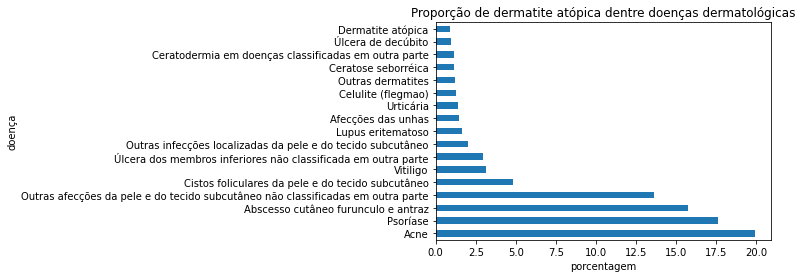

In [37]:
df_l20_proportion.set_index('NO_CID')['PERCENT'][0:17].plot(kind='barh')
plt.title('Proporção de dermatite atópica dentre doenças dermatológicas')
plt.xlabel('porcentagem')
plt.ylabel('doença')

In [38]:
# Create new dataframe containing only L20 registers and relevant columns
selection_sia_l20 = (df_sia.PA_CIDPRI.str[:3] == 'L20') | (df_sia.PA_CIDSEC.str[:3] == 'L20') | (df_sia.PA_CIDCAS.str[:3] == 'L20')

df_sia_l20 = df_sia[selection_sia_l20].loc[:, sia_mask_columns]

In [39]:
# Check filtered dataframe shape
df_sia_l20.shape

(46198, 22)

In [40]:
# Cast numeric dtypes
df_sia_l20[['PA_QTDAPR', 'ANO', 'PA_IDADE']] = df_sia_l20[['PA_QTDAPR', 'ANO', 'PA_IDADE']].astype('int')
df_sia_l20[['PA_VALAPR', 'NU_PA_TOT']] = df_sia_l20[['PA_VALAPR', 'NU_PA_TOT' ]].astype('float')


In [41]:
# Create patient identification key

# Assuming patient's age change year by year, create the attribute 'ANO DE NASCIMENTO'
df_sia_l20['ANO_NASC'] = df_sia_l20.ANO - df_sia_l20.PA_IDADE

# Cast 'ANO_NASC' to string dtype to enable concatenation
df_sia_l20['ANO_NASC'] = df_sia_l20['ANO_NASC'].astype('str')
  
# Concatenate columsn and create key
df_sia_l20['PACIENTE'] = df_sia_l20.PA_MUNPCN.str[2:] + df_sia_l20.ANO_NASC + df_sia_l20.PA_SEXO  # IMPORTANT: For BPA, PA_MUNPCN refers to the health joint city. MOST OF CASES!


In [42]:
# Add column 'NO_UNIDADE', 'TP_UNIDADE, 'NO_GESTAO' from df_cnes
df_sia_l20 = df_sia_l20.join(df_cnes[['CO_CNES', 'TP_UNIDADE', 'NO_GESTAO', 'NO_UNIDADE']].set_index('CO_CNES'), on='PA_CODUNI')

In [43]:
# Add column 'NO_PROCEDIMENTO' from df_proc
df_sia_l20 = df_sia_l20.join(df_proc, on='PA_PROC_ID')

Quais tipos de estabelecimentos de saúde são mais visitados por pacientes de Dermatite Atópica?

In [44]:
df_sia_l20.NO_UNIDADE.value_counts()

PRONTO ATENDIMENTO                                    14197
HOSPITAL ESPECIALIZADO                                11688
HOSPITAL GERAL                                         7694
CENTRO DE SAUDE/UNIDADE BASICA                         4611
CLINICA/CENTRO DE ESPECIALIDADE                        3754
POLICLINICA                                            2187
CENTRAL DE REGULACAO DO ACESSO                          585
PRONTO SOCORRO GERAL                                    473
UNIDADE DE APOIO DIAGNOSE E TERAPIA (SADT ISOLADO)      399
HOSPITAL/DIA - ISOLADO                                  291
PRONTO SOCORRO ESPECIALIZADO                            137
UNIDADE MISTA                                           101
LABORATORIO DE SAUDE PUBLICA                             24
POSTO DE SAUDE                                           22
CENTRAL DE GESTAO EM SAUDE                               22
CENTRAL DE REGULACAO DE SERVICOS DE SAUDE                 7
CENTRO DE APOIO A SAUDE DA FAMILIA      

Quais registros da base TB_SIA_PA contém os medicamentos mencionados pela Eretz.bio para tratamento de Dermatite Atópica?

**R: Ao contrário do que é informado na apresentação, sim, há registros de Dosagem de Ciclosporina através de BPAs. No entanto, NÃO há registros dos outros medicamentos mencionados na apresentação.**

In [45]:
df_sia_l20[df_sia_l20.PA_PROC_ID.isin(df_medication.index)]

,PA_CODUNI,SEVERIDADE,PA_UFMUN,UF,PA_TPUPS,PA_MVM,ANO,MES,PA_PROC_ID,PA_DOCORIG,DOC,PA_AUTORIZ,PA_CIDPRI,PA_CIDSEC,PA_CIDCAS,PA_IDADE,PA_SEXO,PA_RACACOR,PA_MUNPCN,PA_QTDAPR,PA_VALAPR,NU_PA_TOT,ANO_NASC,PACIENTE,TP_UNIDADE,NO_GESTAO,NO_UNIDADE,NO_PROCEDIMENTO
2676775,2078015,NaN,355030,SP,05,201601,2016,01,0202070182,I,BPA-I,0000000000000,L209,0000,0000,9,M,03,355030,1,58.61,58.61,2007,50302007M,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
2681982,2078015,NaN,355030,SP,05,201601,2016,01,0202070182,I,BPA-I,0000000000000,L209,0000,0000,10,F,01,355030,1,58.61,58.61,2006,50302006F,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
2704360,2078015,NaN,355030,SP,05,201602,2016,02,0202070182,I,BPA-I,0000000000000,L209,0000,0000,7,M,01,355030,1,58.61,58.61,2009,50302009M,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
2706888,2077396,NaN,354980,SP,05,201602,2016,02,0202070182,I,BPA-I,0000000000000,L209,0000,0000,9,F,01,353030,1,58.61,58.61,2007,30302007F,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
2730837,2078015,NaN,355030,SP,05,201603,2016,03,0202070182,I,BPA-I,0000000000000,L200,0000,0000,6,M,01,355280,1,58.61,58.61,2010,52802010M,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463088,2078015,NaN,355030,SP,05,202012,2020,12,0202070182,I,BPA-I,0000000000000,L200,0000,0000,15,M,01,355030,1,58.61,58.61,2005,50302005M,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
4474412,2078015,NaN,355030,SP,05,202012,2020,12,0202070182,I,BPA-I,0000000000000,L200,0000,0000,15,F,01,352720,1,58.61,58.61,2005,27202005F,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
4477653,2078015,NaN,355030,SP,05,202012,2020,12,0202070182,I,BPA-I,0000000000000,L209,0000,0000,43,F,02,355030,1,58.61,58.61,1977,50301977F,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA
4781226,2078015,NaN,355030,SP,05,201712,2017,12,0202070182,I,BPA-I,0000000000000,L209,0000,0000,11,M,03,355030,1,58.61,58.61,2006,50302006M,05,ESTADUAL,HOSPITAL GERAL,DOSAGEM DE CICLOSPORINA


In [46]:
df_sia_l20[df_sia_l20.PA_PROC_ID.isin(df_medication.index)].NO_PROCEDIMENTO.value_counts()

DOSAGEM DE CICLOSPORINA    97
Name: NO_PROCEDIMENTO, dtype: int64

In [47]:
df_sia_med = df_sia[df_sia.PA_PROC_ID.isin(df_medication.index)].join(df_medication, on='PA_PROC_ID').groupby(by=['PA_PROC_ID', 'PA_CIDPRI']).agg(
    COUNT=pd.NamedAgg('PA_CIDPRI', 'count'),
    NO_PROCEDIMENTO=pd.NamedAgg('NO_PROCEDIMENTO', 'first')
).sort_values('COUNT', ascending=False).reset_index()

df_sia_med['PA_CIDPRI'] = df_sia_med.PA_CIDPRI.str[:3]

df_sia_med = df_sia_med.groupby(by=['PA_PROC_ID', 'PA_CIDPRI']).agg(
    COUNT=pd.NamedAgg('COUNT', 'sum'),
    NO_PROCEDIMENTO=pd.NamedAgg('NO_PROCEDIMENTO', 'first')
).sort_values('COUNT', ascending=False).join(df_cid_short, on='PA_CIDPRI')

df_sia_med


,,COUNT,NO_PROCEDIMENTO,NO_CID
PA_PROC_ID,PA_CIDPRI,,,
0604710011,L40,66036,"CLOBETASOL 0,5 MG/G CREME (POR BISNAGA DE 30 G)",Psoríase
0604530021,L40,55571,"METOTREXATO 2,5 MG (POR COMPRIMIDO)",Psoríase
0604340044,L40,34461,CICLOSPORINA 100 MG (POR CAPSULA),Psoríase
0604340036,L40,14678,CICLOSPORINA 50 MG (POR CAPSULA),Psoríase
0604530013,L93,13803,AZATIOPRINA 50 MG (POR COMPRIMIDO),Lupus eritematoso
0604530030,L40,13080,METOTREXATO 25 MG/ML INJETAVEL (POR AMPOLA DE ...,Psoríase
0604710020,L40,7220,"CLOBETASOL 0,5 MG/G SOLUÇÃO CAPILAR (POR FRASC...",Psoríase
0604530021,L93,6321,"METOTREXATO 2,5 MG (POR COMPRIMIDO)",Lupus eritematoso
0604340028,L40,2341,CICLOSPORINA 25 MG (POR CAPSULA),Psoríase


Quais são as causas primárias mais frequentes quando o CID L20 é uma uma causa secundária ou associada?

In [48]:
df_sia_l20[df_sia_l20.PA_CIDPRI.str[:3] != 'L20'].PA_CIDPRI.value_counts().to_frame().join(df_cid.set_index('CO_CID')[['NO_CID']])

,PA_CIDPRI,NO_CID
0000,41,NaN
S10,3,Traumatismo superficial do pescoço
I64,3,"Acidente vascular cerebral, não especificado c..."
I209,1,"Angina pectoris, não especificada"


Quais procedimentos da base SIA são mais frequentes em registros relacionados ao CID L20?

In [49]:
proc_count = df_sia_l20.PA_PROC_ID.value_counts().reset_index().rename(columns={'index': 'PA_PROC_ID', 'PA_PROC_ID': 'COUNT'})
proc_count = proc_count.join(df_proc, on='PA_PROC_ID')
proc_count.head(10)

,PA_PROC_ID,COUNT,NO_PROCEDIMENTO
0,0301010072,19556,CONSULTA MEDICA EM ATENÇÃO ESPECIALIZADA
1,0301060096,12255,ATENDIMENTO MEDICO EM UNIDADE DE PRONTO ATENDI...
2,0301060118,3327,ACOLHIMENTO COM CLASSIFICAÇÃO DE RISCO
3,0301010064,1534,CONSULTA MEDICA EM ATENÇÃO PRIMÁRIA
4,0203020030,1384,EXAME ANATOMO-PATOLÓGICO PARA CONGELAMENTO / P...
5,0301060061,911,ATENDIMENTO DE URGENCIA EM ATENCAO ESPECIALIZADA
6,0301060029,755,ATENDIMENTO DE URGENCIA C/ OBSERVACAO ATE 24 H...
7,0201010372,634,BIOPSIA DE PELE E PARTES MOLES
8,0301010048,474,CONSULTA DE PROFISSIONAIS DE NIVEL SUPERIOR NA...
9,0301010030,405,CONSULTA DE PROFISSIONAIS DE NÍVEL SUPERIOR NA...


In [50]:
# Check inconsistent quantities x values
df_sia_l20[(df_sia_l20.PA_QTDAPR > 1) & (df_sia_l20.PA_VALAPR == 0)].loc[:,['DOC', 'PA_QTDAPR', 'PA_VALAPR', 'NU_PA_TOT', 'PA_PROC_ID']].sort_values(
    'PA_VALAPR', ascending=False
).join(df_proc, on='PA_PROC_ID')

,DOC,PA_QTDAPR,PA_VALAPR,NU_PA_TOT,PA_PROC_ID,NO_PROCEDIMENTO
9481,BPA-I,2,0.0,0.00,0301010064,CONSULTA MEDICA EM ATENÇÃO PRIMÁRIA
759401,BPA-I,2,0.0,0.00,0301010064,CONSULTA MEDICA EM ATENÇÃO PRIMÁRIA
4949260,RAAS-AD,5,0.0,4.67,0302050027,ATENDIMENTO FISIOTERAPÊUTICO NAS ALTERAÇÕES MO...
4949259,RAAS-AD,2,0.0,0.00,0101030029,VISITA DOMICILIAR/INSTITUCIONAL POR PROFISSION...
4886659,RAAS-AD,3,0.0,0.00,0301050147,VISITA DOMICILIAR POR PROFISSIONAL DE NÍVEL SU...
4886658,RAAS-AD,5,0.0,4.67,0302050027,ATENDIMENTO FISIOTERAPÊUTICO NAS ALTERAÇÕES MO...
4886655,RAAS-AD,2,0.0,0.00,0101030029,VISITA DOMICILIAR/INSTITUCIONAL POR PROFISSION...
4746488,RAAS-AD,5,0.0,4.67,0302050027,ATENDIMENTO FISIOTERAPÊUTICO NAS ALTERAÇÕES MO...
4746432,RAAS-AD,2,0.0,0.00,0101030029,VISITA DOMICILIAR/INSTITUCIONAL POR PROFISSION...
4746431,RAAS-AD,3,0.0,0.00,0301050147,VISITA DOMICILIAR POR PROFISSIONAL DE NÍVEL SU...


Como é possível ver abaixo, alguns procedimentos de fato não tem valores informados na base **tb_sigtap_procedimento**. Como o único procedimento com valor disponível é baixo (0302050027), o impacto nos valores totais de procedimentos é desprezível e nenhuma modificação/correção será feita no data frame df_sia_l20 para manter a simplicidade.

In [51]:
# Search for missiving values in df_sigtap

missing_price = df_sia_l20[(df_sia_l20.PA_QTDAPR > 1) & (df_sia_l20.PA_VALAPR == 0)].PA_PROC_ID.unique()
df_mp = pd.DataFrame({}, index=missing_price)
df_mp = df_mp.join(df_sigtap.set_index('CO_PROCEDIMENTO')[['VL_SH', 'VL_SA', 'VL_SP']])
df_mp.reset_index().groupby('index').agg(
    VL_SA=pd.NamedAgg('VL_SA', 'max')
)

,VL_SA
index,
0101030029,0000000000
0214010015,0000000000
0301010064,0000000000
0301050147,0000000000
0301060037,0000000000
0301100039,0000000000
0301100101,0000000000
0301100195,0000000000
0301100209,0000000000


In [52]:
# Values by year and type of document (L20 as PRIMARY OR SECONDARY cause)
df_sia_l20.groupby('ANO').agg(
    COUNT_REG = pd.NamedAgg('ANO', 'count'),
    SUM_PA_VALAPR = pd.NamedAgg('PA_VALAPR', 'sum')
)

,COUNT_REG,SUM_PA_VALAPR
ANO,,
2016,3982,59763.76
2017,9294,101265.50
2018,9742,103282.10
2019,13122,161285.46
2020,10058,104843.52


In [53]:
# Values by year (L20 as SECONDARY CAUSE only)
df_sia_l20[df_sia_l20.PA_CIDPRI.str[:3] != 'L20'].groupby('ANO').agg(
    COUNT_REG = pd.NamedAgg('ANO', 'count'),
    SUM_PA_VALAPR = pd.NamedAgg('PA_VALAPR', 'sum')
)

,COUNT_REG,SUM_PA_VALAPR
ANO,,
2016,18,0.00
2017,1,614.72
2020,29,1985.10


In [54]:
# Check number of registers per 'documento de origem'
df_sia_l20_origem = df_sia_l20.DOC.value_counts().to_frame()
df_sia_l20_origem['PORCENTAGEM'] = round(df_sia_l20_origem.DOC / df_sia_l20_origem.DOC.sum() * 100, 2)
df_sia_l20_origem

,DOC,PORCENTAGEM
BPA-I,46150,99.90
APAC-S,28,0.06
RAAS-AD,18,0.04
APAC-P,2,0.00


###TB_SIH_RD###
Base de Dados Principal

Sistema de Informações Hospitalares do SUS
RD – AIH Reduzida

A base carregada no Google Drive foi filtrada localmente e contém somente os registros de doenças de pele (CID-10 grupo XII, Lxxx) como causas primária ou secundárias.

In [55]:
# Create df
folder_path = Path() / 'data' / 'tb_sih_rd'
df_sih = pd.read_parquet(folder_path, engine='pyarrow')

In [56]:
# Check df shape
df_sih.shape

(1321330, 113)

In [57]:
# Check column 'SEXO' value counts
df_sih.SEXO.value_counts()

1    732052
3    589278
Name: SEXO, dtype: int64

In [58]:
# Column 'SEXO' dictionary as per auxiliary file TAB_SIH.zip/CNV/SEXO.CNV
sex = {
    '1': 'M',  # Masculino
    '3': 'F'  # Feminino
}

In [59]:
# Create auxiliary columns
df_sih['ANO_NASC'] = df_sih.NASC.str[:4].astype(int)
df_sih['ANO_CMPT'] = df_sih['ANO_CMPT'].astype(int)
df_sih['IDADE'] = df_sih.ANO_CMPT - df_sih.ANO_NASC
df_sih['SEXO'] = df_sih.SEXO.map(sex)  # To make it same as tb_sia_pa 'PA_SEXO' values (M/F)
df_sih['PACIENTE'] = df_sih.MUNIC_RES.str[2:] + df_sih.ANO_NASC.astype(str) + df_sih.SEXO
df_sih['SEVERIDADE'] = 'GRAVE'
df_sih['DOC'] = 'AIH'
df_sih['UF'] = df_sih.MUNIC_MOV.str[:2]
df_sih['UF'] = df_sih.UF.map(UF)

In [60]:
sih_mask_columns = ['PACIENTE',  # Chave de identificação do paciente ('MUNIC' + 'ANO_NASC' + 'SEXO)
                    # 'PACIENTE_F',  # Chave id usando data de nascimento inteira ('MUNIC' + 'NASC' + 'SEXO)
                    'SEVERIDADE', # Severidade do caso (para SIH/AIH, todos são casos severos)
                    'ANO_CMPT',  # Ano de processamento da AIH
                    'MES_CMPT',  # Mês de processamento da AIH 
                    'DOC',  # CRIADA
                    'N_AIH',  # Número da AIH
                    'IDENT',  # Identificação do tipo da AIH
                    'CEP',  # CEP do paciente
                    'MUNIC_RES',  # Município de residência do paciente
                    'NASC',  # Data de nascimento do pacinte (aaaammdd)
                    'ANO_NASC', # Ano de nascimento
                    'IDADE',  # CRIADA
                    'SEXO',  # Sexo do paciente
                    'UTI_MES_TO',  # Quantidade de diárias na UTI no mês
                    'UTI_INT_TO',  # Quantidade de diárias em unidade intermediária
                    'DIAR_ACOM',  # Quantidade de diárias de acompanhante
                    'QT_DIARIAS',  # Quantidade de diárias
                    # 'PROC_SOLIC',  # Procedimento solicitado
                    'PROC_REA',  # Procedimento realizado
                    'VAL_SH',  # Valor de serviços hospitalares
                    'VAL_SP',  # Valor de serviços profissionais
                    'VAL_TOT',  # Valor total da AIH
                    'VAL_UTI',  # Valor UTI
                    'DIAG_PRINC',  # CID10 do diagnóstico principal
                    # 'DIAG_SECUN',  # CID10 diagnóstico secundário. Preenchido com zeros a partir de 201501 // NÃO CONTÉM L20
                    # 'CID_NOTIF',  # CID de notificação // NÃO CONTÉM L20
                    'CNES',  # Código CNES do hospital
                    'MUNIC_MOV',  # Código UF + MUNI do estabelecimento
                    'UF',  # UF do estabelecimento
                    # 'CID_ASSO',  # CID causa // NÃO CONTÉM L20
                    # 'CID_MORTE',  # CID da morte // NÃO CONTÉM L20
                    'DIAGSEC1',
                    'DIAGSEC2',
                    'DIAGSEC3',
                    'DIAGSEC4',
                    'DIAGSEC5',
                    'DIAGSEC6',
                    'DIAGSEC7',
                    'MORTE']
                    # 'DIAGSEC8',  # NÃO CONTÉM L20
                    # 'DIAGSEC9'  # NÃO CONTÉM L20

In [61]:
# Check number of 'L20' (DA) registers per column
cid_columns = ['DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'DIAGSEC5', 'DIAGSEC6', 'DIAGSEC7']

d = {}
for column in cid_columns:
    s = df_sih[column].str[:3] == 'L20'
    s = s.agg('sum')
    d[column] = [s]

pd.DataFrame.from_dict(d)

,DIAG_PRINC,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,DIAGSEC5,DIAGSEC6,DIAGSEC7
0,4756,471,146,44,15,3,2,2


In [62]:
selection_l20 = (df_sih.DIAG_PRINC.str[:3] == 'L20') | (df_sih.DIAGSEC1.str[:3] == 'L20') | (df_sih.DIAGSEC2.str[:3] == 'L20') | \
                (df_sih.DIAGSEC3.str[:3] == 'L20') | (df_sih.DIAGSEC4.str[:3] == 'L20') | (df_sih.DIAGSEC5.str[:3] == 'L20') | \
                (df_sih.DIAGSEC6.str[:3] == 'L20') | (df_sih.DIAGSEC7.str[:3] == 'L20')

In [63]:
# Create new dataframe containing only L20 registers and relevant columns
df_sih_l20 = df_sih[selection_l20].loc[:, sih_mask_columns]

In [64]:
# Add column 'NO_UNIDADE', 'TP_UNIDADE, 'NO_GESTAO' from df_cnes
df_sih_l20 = df_sih_l20.join(df_cnes[['CO_CNES', 'TP_UNIDADE', 'NO_GESTAO', 'NO_UNIDADE']].set_index('CO_CNES'), on='CNES')

In [65]:
# Add column 'NO_PROCEDIMENTO from df_proc
df_sih_l20 = df_sih_l20.join(df_proc, on='PROC_REA')

In [66]:
# Check filtered df shape
df_sih_l20.shape

(5426, 38)

In [67]:
# Cast numeric dtypes
df_sih_l20[['UTI_MES_TO', 'UTI_INT_TO', 'DIAR_ACOM', 'QT_DIARIAS']] = df_sih_l20[['UTI_MES_TO', 'UTI_INT_TO', 'DIAR_ACOM', 'QT_DIARIAS']].astype('int')
df_sih_l20[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'VAL_UTI']] = df_sih_l20[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'VAL_UTI']].astype('float')


In [68]:
# Show filtered df
df_sih_l20.head()

,PACIENTE,SEVERIDADE,ANO_CMPT,MES_CMPT,DOC,N_AIH,IDENT,CEP,MUNIC_RES,NASC,ANO_NASC,IDADE,SEXO,UTI_MES_TO,UTI_INT_TO,DIAR_ACOM,QT_DIARIAS,PROC_REA,VAL_SH,VAL_SP,VAL_TOT,VAL_UTI,DIAG_PRINC,CNES,MUNIC_MOV,UF,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,DIAGSEC5,DIAGSEC6,DIAGSEC7,MORTE,TP_UNIDADE,NO_GESTAO,NO_UNIDADE,NO_PROCEDIMENTO
147,09502016M,GRAVE,2017,05,AIH,3517101072090,1,13069096,350950,20160826,2016,1,M,0,0,5,6,0303140135,737.20,44.10,781.30,0.0,J960,2079798,350950,SP,J218,L209,None,None,None,None,None,0,05,ESTADUAL,HOSPITAL GERAL,TRATAMENTO DE OUTRAS DOENCAS DO APARELHO RESPI...
253,50302011M,GRAVE,2017,05,AIH,3517108914594,1,05405150,355030,20111210,2011,6,M,0,0,2,2,0303140046,723.27,38.56,761.83,0.0,J46,2078015,355030,SP,J304,L209,None,None,None,None,None,0,05,ESTADUAL,HOSPITAL GERAL,TRATAMENTO DAS DOENCAS CRONICAS DAS VIAS AEREA...
265,50302004M,GRAVE,2017,05,AIH,3517108318207,1,02992060,355030,20041112,2004,13,M,0,0,1,1,0301060010,43.65,11.62,55.27,0.0,L209,2078015,355030,SP,None,None,None,None,None,None,None,0,05,ESTADUAL,HOSPITAL GERAL,DIAGNOSTICO E/OU ATENDIMENTO DE URGENCIA EM CL...
279,50302013F,GRAVE,2017,05,AIH,3517114214702,1,04855450,355030,20130713,2013,4,F,0,0,5,5,0303140143,485.14,35.78,520.92,0.0,J219,2077671,355030,SP,J459,R05,R060,L209,None,None,None,0,05,ESTADUAL,HOSPITAL GERAL,TRATAMENTO DE OUTRAS INFECCOES AGUDAS DAS VIAS...
785,10702011M,GRAVE,2017,05,AIH,3517113622869,1,15570000,351070,20111105,2011,6,M,0,0,2,2,0303080051,207.85,33.06,240.91,0.0,L208,2082071,351070,SP,None,None,None,None,None,None,None,0,05,ESTADUAL,HOSPITAL GERAL,TRATAMENTO DE DERMATITES E ECZEMAS


In [69]:
# Which procedures are most common in SIH?
proc_count_sih = df_sih_l20.PROC_REA.value_counts().reset_index().rename(columns={'index': 'PROC_REA', 'PROC_REA': 'COUNT'})
proc_count_sih = proc_count_sih.join(df_proc, on='PROC_REA')
proc_count_sih.head(10)

,PROC_REA,COUNT,NO_PROCEDIMENTO
0,0303080051,4162,TRATAMENTO DE DERMATITES E ECZEMAS
1,0303080060,175,TRATAMENTO DE ESTAFILOCOCCIAS
2,0301060010,168,DIAGNOSTICO E/OU ATENDIMENTO DE URGENCIA EM CL...
3,0303080094,137,TRATAMENTO DE OUTRAS AFECCOES DA PELE E DO TEC...
4,0301060088,87,DIAGNOSTICO E/OU ATENDIMENTO DE URGENCIA EM CL...
5,0303010037,78,TRATAMENTO DE OUTRAS DOENÇAS BACTERIANAS
6,0303080078,73,TRATAMENTO DE ESTREPTOCOCCIAS
7,0303140046,69,TRATAMENTO DAS DOENCAS CRONICAS DAS VIAS AEREA...
8,0303140151,41,TRATAMENTO DE PNEUMONIAS OU INFLUENZA (GRIPE)
9,0303140143,30,TRATAMENTO DE OUTRAS INFECCOES AGUDAS DAS VIAS...


Quais registros da base TB_SIH_RD contém os medicamentos mencionados pela Eretz.bio para tratamento de Dermatite Atópica?

**R: Nenhum registro de medicamento para Dermatite Atópica dispensados através de AIH.**

In [70]:
df_medication.index

Index(['0202060446', '0202070182', '0202070298', '0501080031', '0501080058',
       '0603020011', '0603020020', '0603020038', '0603020046', '0603020054',
       '0603080022', '0603080030', '0603080049', '0603080057', '0603080138',
       '0603080197', '0603080200', '0603080219', '0604320051', '0604340010',
       '0604340028', '0604340036', '0604340044', '0604340052', '0604340060',
       '0604340079', '0604530013', '0604530021', '0604530030', '0604710011',
       '0604710020'],
      dtype='object', name='CO_PROCEDIMENTO')

In [71]:
df_sih_l20[df_sih_l20.PROC_REA.isin(df_medication.index)]

,PACIENTE,SEVERIDADE,ANO_CMPT,MES_CMPT,DOC,N_AIH,IDENT,CEP,MUNIC_RES,NASC,ANO_NASC,IDADE,SEXO,UTI_MES_TO,UTI_INT_TO,DIAR_ACOM,QT_DIARIAS,PROC_REA,VAL_SH,VAL_SP,VAL_TOT,VAL_UTI,DIAG_PRINC,CNES,MUNIC_MOV,UF,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,DIAGSEC5,DIAGSEC6,DIAGSEC7,MORTE,TP_UNIDADE,NO_GESTAO,NO_UNIDADE,NO_PROCEDIMENTO


Existem registros da base TB_SIH_RD de realização de FOTOTERAPIA?

**R: Não!**

In [72]:
df_phototherapy.index

Index(['0303080108', '0303080116'], dtype='object', name='CO_PROCEDIMENTO')

In [73]:
df_sih_l20[df_sih_l20.PROC_REA.isin(df_phototherapy.index)]

,PACIENTE,SEVERIDADE,ANO_CMPT,MES_CMPT,DOC,N_AIH,IDENT,CEP,MUNIC_RES,NASC,ANO_NASC,IDADE,SEXO,UTI_MES_TO,UTI_INT_TO,DIAR_ACOM,QT_DIARIAS,PROC_REA,VAL_SH,VAL_SP,VAL_TOT,VAL_UTI,DIAG_PRINC,CNES,MUNIC_MOV,UF,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,DIAGSEC5,DIAGSEC6,DIAGSEC7,MORTE,TP_UNIDADE,NO_GESTAO,NO_UNIDADE,NO_PROCEDIMENTO


Quais CIDs primários são mais frequentes quando o CID secundário é L20?

In [74]:
df_sih_l20[df_sih_l20.DIAG_PRINC.str[:3] != 'L20'].DIAG_PRINC.str[:3].value_counts().to_frame().join(df_cid_short).head(20)

,DIAG_PRINC,NO_CID
J45,60,Asma
A49,58,Infecção bacteriana de localização não especif...
L03,49,Celulite (flegmao)
J18,31,Pneumonia por microorganismo não especificada
J21,27,Bronquiolite aguda
L98,23,Outras afecções da pele e do tecido subcutâneo...
L01,23,Impetigo
L08,21,Outras infecções localizadas da pele e do teci...
B95,19,Estreptococos e estafilococos como causa de do...
A41,16,Outras septicemias


In [75]:
# Values by year (considering L20 as PRIMARY AND SECONDARY CID)
df_sih_l20.groupby('ANO_CMPT').agg(
    COUNT_REGISTERS = pd.NamedAgg('ANO_CMPT', 'count'),
    SUM_VAL_TOT = pd.NamedAgg('VAL_TOT', 'sum')
)

,COUNT_REGISTERS,SUM_VAL_TOT
ANO_CMPT,,
2016,1087,386987.79
2017,1067,375277.91
2018,1223,461428.09
2019,1190,456393.52
2020,859,471770.96


In [76]:
# Values by year (considering L20 as SECONDARY CID ONLY)
df_sih_l20[df_sih_l20.DIAG_PRINC.str[:3] != 'L20'].groupby('ANO_CMPT').agg(
    COUNT_REGISTERS = pd.NamedAgg('ANO_CMPT', 'count'),
    SUM_VAL_TOT = pd.NamedAgg('VAL_TOT', 'sum')
)

,COUNT_REGISTERS,SUM_VAL_TOT
ANO_CMPT,,
2016,98,85689.27
2017,117,78492.55
2018,155,133133.35
2019,161,130189.98
2020,139,185484.65


Há chaves de identificação de paciente iguais nas duas bases principais, SIA e SIH?


In [77]:
print('NÚMERO ESTIMADO DE PACIENTES ÚNICOS')

patients_sih = df_sih_l20.PACIENTE.unique()
print(f'Presentes no df_sih_l20: {len(patients_sih):10}')

patients_sia = df_sia_l20.PACIENTE.unique()
print(f'Presentes no df_sia_l20: {len(patients_sia):10}')

patients_in_both = df_sia_l20[df_sia_l20.PACIENTE.isin(patients_sih)].PACIENTE.unique()
print(f'Em ambos data frames: {len(patients_in_both):13}')

patients_sih_only = df_sih_l20[~(df_sih_l20.PACIENTE.isin(patients_sia))].PACIENTE.nunique()
print(f'Apenas no sih_l20: {patients_sih_only:16}')


NÚMERO ESTIMADO DE PACIENTES ÚNICOS
Presentes no df_sih_l20:       3599
Presentes no df_sia_l20:       9457
Em ambos data frames:          1062
Apenas no sih_l20:             2537


##**DEFINIÇÃO DE SEVERIDADE**##

<p>De acordo com a análise exploratória das bases de dados SIA (Produção Ambulatorial) e SIH (Internações Hospitalares) realizada nesse notebook, considerando que:</p>

1. Dos medicamentos mencionados pela apresentação 'Datathon Abbvie - Análise das bases' fornecida pelo time Eretz.bio, apenas a **Ciclosporina** foi encontrada nas bases de dados em registros (**97 registros provenientes de BPA-I**) que tinham o CID10 L20, Dermatite Atópica, como causa principal ou causas secundárias;
2. Não foram encontrados registros de tratamentos de **Fototerapia ou Fototerapia com sensibilização** realizados para o CID10 L20 como causa principal e/ ou causas secundárias;
3. Não foram encontrados registros de **corticosteróides ou inibidores de calcineurina** dispensados para o CID10 L20 como causa principal e/ou causas secundárias, o que impede uma clara divisão entre casos Leves e Moderados de DA.<br>

<p>Optamos por classificar os casos de Dermatite Atópica da seguinte forma:</p>

| Severidade | Definição baseada no histórico de tratamento entre 2016 e 2020 |
| -------------------------- | ----------------------- |
| GRAVE | - Pacientes que foram internados (AIH) pelo menos uma vez no período |
|  | - Pacientes que receberam ciclosporina |
|  | - Pacientes que usaram algum estabelecimento de saúde do tipo Emergência (ex.: Pronto Atendimentos |
|  | - Pacientes que receberam algum procedimento de Emergência |
|  | - Pacientes que geraram registros de APAC |
| LEVE/MODERADO | - Qualquer paciente que não se enquadrou em nenhum dos critérios considerados graves |


Como as bases de dados são públicas e não há nenhum campo que identifica cada paciente de maneira única, optamos por criar uma chave de identificação artificial através da concatenação dos campos de Município + Ano de Nascimento + Sexo. Apesar de imperfeito, considerando que apenas 0,87% de todos os registros ambulatoriais doenças de pele (CID10 capítulo XII), essa abordagem parece ser a que faz mais sentido e a que possibilita manter um controle, ainda que limitado, da progressão dos pacientes ao longo do tempo.

In [78]:
# 'GRAVE'

# Patients who were hospitalized
df_sia_l20.loc[df_sia_l20.PACIENTE.isin(patients_in_both), 'SEVERIDADE'] = 'GRAVE'

# High complexity procedures (APAC)
df_sia_l20.loc[df_sia_l20.DOC.str.contains('APAC'), 'SEVERIDADE'] = 'GRAVE'

# Cyclosporine dispensed
df_sia_l20.loc[df_sia_l20.PA_PROC_ID.isin(ciclosporina), 'SEVERIDADE'] = 'GRAVE'

# Emergency services
df_sia_l20.loc[df_sia_l20.TP_UNIDADE.isin(emergency_cnes_types), 'SEVERIDADE'] = 'GRAVE'

# Emergency procedures
df_sia_l20.loc[df_sia_l20.PA_PROC_ID.isin(emergency_procedures), 'SEVERIDADE'] = 'GRAVE'


# 'LEVE/MODERADA'
# All registers not considered 'GRAVE'
df_sia_l20.loc[df_sia_l20.SEVERIDADE.isnull(), 'SEVERIDADE'] = 'LEVE/MODERADA'

In [79]:
severity = df_sia_l20.SEVERIDADE.value_counts().to_frame()
severity['PORCENTAGEM'] = round(severity.SEVERIDADE / severity.SEVERIDADE.sum() * 100, 1)
severity.rename(columns={'SEVERIDADE': 'REGISTROS'})

,REGISTROS,PORCENTAGEM
GRAVE,31223,67.6
LEVE/MODERADA,14975,32.4


##**RESPOSTAS PARA O DESAFIO**##

###**PERGUNTA 1**###
**Qual o custo anual médio dos pacientes com dermatite atópica
moderada a grave para o sistema público de saúde?**<br>

Para responder essa pergunta as bases principais (SIA e SIH) serão combinadas/concatenadas para oferecer um visão total dos valores e outras estatísticas.

Além disso, serão considerados apenas os registros de L20 como causa primária. No caso de atendimentos ambulatoriais (SIA), os custos relacionados a registros de L20 como causa secundária são irrelevantes. No caso de internações hospitalares, os valores de registros com L20 como causa secundária ultrapassam a média de R$ 123.000,00 por ano. No entanto, não parece correto considerar esse valores, uma vez que as causas primárias são as mais variadas (asma, pneumonia, celulite, infecções diversas, bronquiolite, etc) e apesar de poder existir relação entre a dermatite atópica e essas outras enfermidades, a causa primária de internação não foi a dermatite.

In [80]:
# Select columns from both main data sets for concatenation

sia_cols = ['SEVERIDADE',  # Severidade da dermatite atópica
            'PACIENTE',  # Chave artificial de identificação úncia de paciente
            'PA_IDADE',  # Idade do paciente
            'PA_SEXO',  # Sexo do paciente
            'PA_MUNPCN',  # UF + Município de residência do paciente (APAC) / Igual e PA_UFMUN para BPA
            'PA_CODUNI',  # CNES do estabelecimento de saúde
            'TP_UNIDADE',  # Código do tipo do estabelecimento de saúde
            'NO_UNIDADE',  # Descrição do tipo do estabelecimento de saúde
            'NO_GESTAO',  # Tipo de gestão (Municipal / Estadual / Federal)
            'PA_UFMUN',  # Código UF + MUNI do estabelecimento de saúde
            'UF',  # UF do estabelecimento de sáude
            'ANO',  # Ano do atendimento
            'MES',  # Mês do atendimento
            'PA_PROC_ID',  # Código do procedimento/medicamento
            'NO_PROCEDIMENTO',  # Descrição do procedimento/medicamento
            'DOC',  # Tipo do documento (BPA / APAC / RAAS)
            'PA_VALAPR',  # Valor aprovado total
            'PA_CIDPRI']  # CID primário
  
sih_cols = ['SEVERIDADE',
            'PACIENTE',
            'IDADE',
            'SEXO',
            'MUNIC_RES',
            'CNES',
            'TP_UNIDADE',
            'NO_UNIDADE',
            'NO_GESTAO',
            'MUNIC_MOV',
            'UF',
            'ANO_CMPT',
            'MES_CMPT',
            'PROC_REA',
            'NO_PROCEDIMENTO',
            'DOC',
            'VAL_TOT',
            'DIAG_PRINC',
            'MORTE']

# Dictionary to rename columns of SIH to concatenate to SIA
rename_map = {a: b for a, b in zip(sih_cols, sia_cols)}

In [81]:
# Prepare (rename columns) df_sih_l20 to be appended to SIA
sih = df_sih_l20.loc[df_sih_l20.DIAG_PRINC.str[:3] == 'L20', sih_cols]
sih.rename(columns=rename_map, inplace=True)

In [82]:
# Apend SIA and SIH creating a summary dataframe
df = df_sia_l20.loc[df_sia_l20.PA_CIDPRI.str[:3] == 'L20', sia_cols].append(sih, ignore_index=True)

In [83]:
# Fill NA values in 'MORTE' columsn with 0
df.MORTE.fillna(0, inplace=True)
df.MORTE = df.MORTE.astype(int)

In [84]:
# Total cost per year per severity
summary = df.groupby(['ANO', 'SEVERIDADE']).agg(
    VALOR=pd.NamedAgg('PA_VALAPR', 'sum')
)

summary

VALOR
ANO  SEVERIDADE              
2016 GRAVE          321618.09
     LEVE/MODERADA   39444.19
2017 GRAVE          352069.46
     LEVE/MODERADA   45366.68
2018 GRAVE          396038.46
     LEVE/MODERADA   35538.38
2019 GRAVE          414276.82
     LEVE/MODERADA   73212.18
2020 GRAVE          347234.23
     LEVE/MODERADA   41910.50

In [ ]:
fig = px.bar(summary.reset_index(), x='ANO', y='VALOR', color='SEVERIDADE', title='Custo total por tipo de severidade')
fig.show()

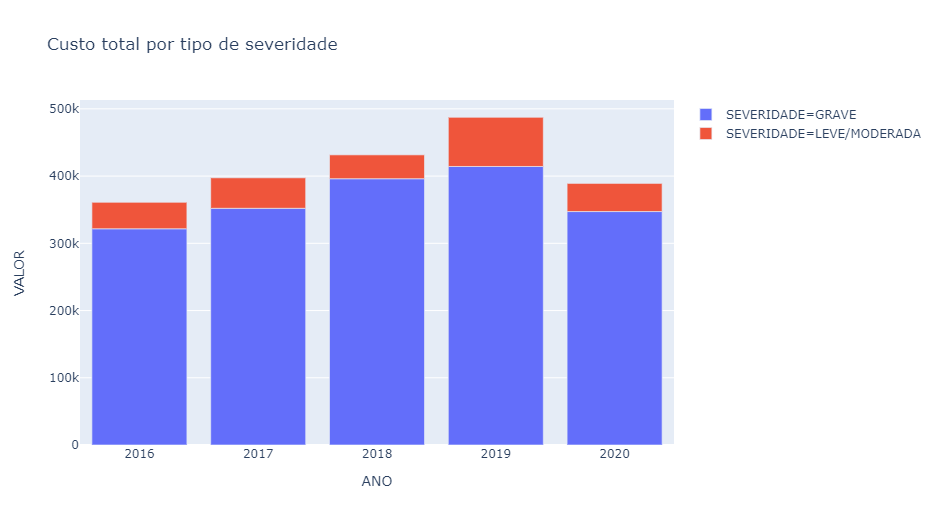

In [86]:
# Mean total cost per year 
round(df.groupby('ANO')[['PA_VALAPR']].sum().PA_VALAPR.mean(), 2)

413341.8

###**PERGUNTA 2**###
**Como se caracteriza a utilização de recursos do sistema de saúde por
pacientes com dermatite atópica moderada a grave?**


**2.1 Quantos pacientes atendidos com CID L20 em um ano?**

A consulta retorna a quantidade de pacientes únicos atendidos por ano. Isso quer dizer que o mesmo paciente pode ter sido atendido uma ou mais vezes.

In [87]:
pacientes_ano=df.groupby('ANO').agg(
    PACIENTES=pd.NamedAgg('PACIENTE', 'nunique')
)

In [88]:
pacientes_ano

,PACIENTES
ANO,
2016,2195
2017,2981
2018,3472
2019,4995
2020,4374


In [ ]:
px.bar(pacientes_ano.reset_index(),x='ANO',y='PACIENTES',title='Pacientes com CID L20 atendidos por ano')

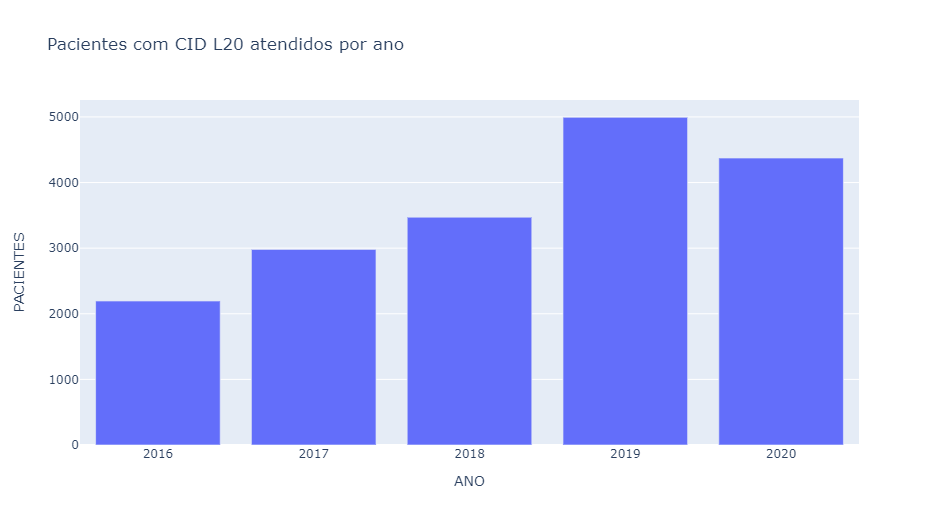

**2.2.1 Quantos pacientes atendidos em serviços de emergência? E quantos são ambulatoriais?**

A consulta retorna a quantidade de pacientes únicos atendidos por tipo de serviço por ano. Cada paciente único poder ter sido antendido uma ou mais vezes

In [90]:
# Create column to identify health service type "AMBULATORIAL/EMERGÊNCIA/INTERNAÇÃO" based on type of health service location.
df['TIPO_ATENDIMENTO'] = np.nan
df.loc[df.DOC == 'AIH', 'TIPO_ATENDIMENTO'] = 'INTERNAÇÃO'
df.loc[(df.TP_UNIDADE.isin(emergency_cnes_types)) & (df.TIPO_ATENDIMENTO.isnull()), 'TIPO_ATENDIMENTO'] = 'EMERGÊNCIA'
df.loc[df.TIPO_ATENDIMENTO.isnull(), 'TIPO_ATENDIMENTO'] = 'AMBULATORIAL' 

In [91]:
tipo_atendimento = df[df.TIPO_ATENDIMENTO != 'INTERNAÇÃO'].groupby(['ANO', 'TIPO_ATENDIMENTO']).agg(
    PACIENTES=pd.NamedAgg('PACIENTE', 'nunique')
)

tipo_atendimento

PACIENTES
ANO  TIPO_ATENDIMENTO           
2016 AMBULATORIAL           1393
     EMERGÊNCIA               80
2017 AMBULATORIAL           1793
     EMERGÊNCIA              647
2018 AMBULATORIAL           1737
     EMERGÊNCIA             1157
2019 AMBULATORIAL           2733
     EMERGÊNCIA             1741
2020 AMBULATORIAL           2270
     EMERGÊNCIA             1758

In [ ]:
px.bar(tipo_atendimento.reset_index(),x='ANO',y='PACIENTES',color='TIPO_ATENDIMENTO',title='Quantos pacientes atendidos em serviços de emergência? E quantos são ambulatoriais?')

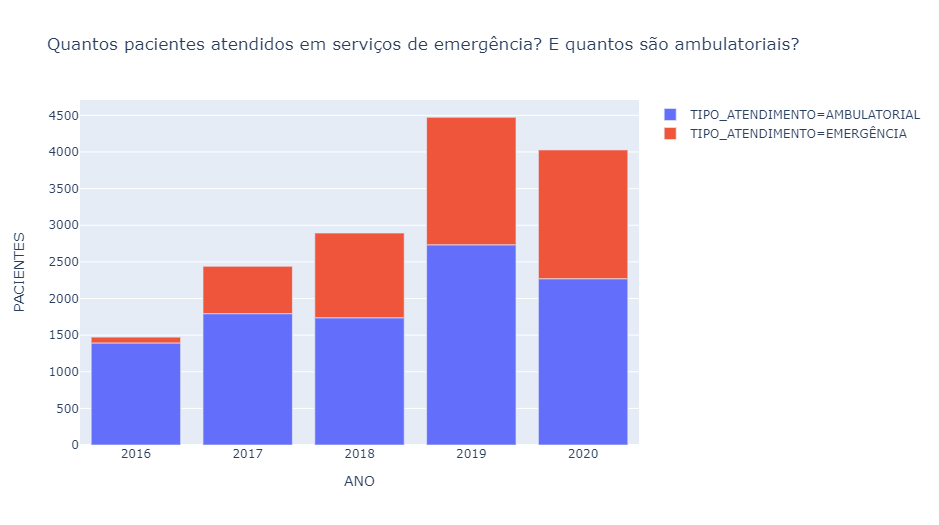

**2.2.2 Qual a faixa etária mais comum em cada um desses locais?**

Faixas etárias: De 0 a 6 anos, de 6 a 12, de 12 a 18 anos, 18 a 30, 30 a 50 e maiores de 50 anos

In [93]:
# Create column 'FAIXA_ETARIA'
df['FAIXA_ETARIA'] = np.nan
df.FAIXA_ETARIA = pd.cut(df.PA_IDADE, [0, 5, 11, 17, 29, 49, 150], labels=['0-6', '6-12', '12-18', '18-30', '30-50', '50+'], include_lowest=True)

In [94]:
age_groups = df.groupby(['TIPO_ATENDIMENTO', 'FAIXA_ETARIA']).agg(
      PACIENTES=pd.NamedAgg('PACIENTE', 'nunique')
)

age_groups['PORCENTAGEM'] = np.NaN

for atendimento in df.TIPO_ATENDIMENTO.unique():
  total = age_groups.loc[atendimento].PACIENTES.sum()
  age_groups.loc[atendimento, 'PORCENTAGEM'] = round(age_groups.PACIENTES / total * 100, 1)

age_groups

PACIENTES  PORCENTAGEM
TIPO_ATENDIMENTO FAIXA_ETARIA                        
AMBULATORIAL     0-6                1294         17.9
                 6-12               1070         14.8
                 12-18               758         10.5
                 18-30               954         13.2
                 30-50              1349         18.7
                 50+                1796         24.9
EMERGÊNCIA       0-6                 617         17.3
                 6-12                365         10.2
                 12-18               295          8.2
                 18-30               609         17.0
                 30-50               807         22.6
                 50+                 883         24.7
INTERNAÇÃO       0-6                1393         40.8
                 6-12                631         18.5
                 12-18               326          9.5
                 18-30               248          7.3
                 30-50               285          8.3
                 50+                 535         15.7

**2.2.3 Qual o número de consultas ambulatoriais e emergenciais por paciente por mês?**

Para essa análise, assumimos que cada registro de BPA-I na tabela SIA de produção ambulatorial representa um atendimento ou consulta. O informe técnico 2016-03 SIASUS declara que "*há casos de registros de um ou mais atendimentos no BPA-I para o mesmo paciente*", mas é impossível identificar esses casos e serão considerados exceção. Como os campos de data da tabela não registram o dia dos atendimentos (apenas ano/mês, não é possível controlar artificialmente essa questão.

In [95]:
# Most of registers come from BPA-I documents.
df_sia_l20_origem

,DOC,PORCENTAGEM
BPA-I,46150,99.90
APAC-S,28,0.06
RAAS-AD,18,0.04
APAC-P,2,0.00


In [96]:
# It's impossible uniquely identify each BPA-I.
df_sia_l20[['PA_AUTORIZ', 'DOC', 'PA_MVM']].groupby(['DOC', 'PA_AUTORIZ']).count().sort_values('PA_MVM', ascending=False).head()

PA_MVM
DOC   PA_AUTORIZ           
BPA-I 0000000000000   42837
      2660000000000     363
      2019000000001     137
      2710000000000      86
      2020000000001      78

In [97]:
media_atendimento = df[df.TIPO_ATENDIMENTO != 'INTERNAÇÃO'].groupby(['TIPO_ATENDIMENTO', 'ANO', 'MES']).agg(
    ATENDIMENTOS=pd.NamedAgg('TIPO_ATENDIMENTO', 'count')
).reset_index().groupby(['TIPO_ATENDIMENTO', 'ANO']).agg(
    MEDIA_ATEND_MÊS=pd.NamedAgg('ATENDIMENTOS','mean')
)

media_atendimento

MEDIA_ATEND_MÊS
TIPO_ATENDIMENTO ANO                  
AMBULATORIAL     2016       317.083333
                 2017       655.416667
                 2018       534.750000
                 2019       663.416667
                 2020       441.166667
EMERGÊNCIA       2016        14.454545
                 2017       119.000000
                 2018       277.083333
                 2019       430.083333
                 2020       394.583333

In [ ]:
px.bar(media_atendimento.reset_index(),x='ANO',y='MEDIA_ATEND_MÊS',color='TIPO_ATENDIMENTO',title='Média de atendimentos ambulatoriais e emergenciais')

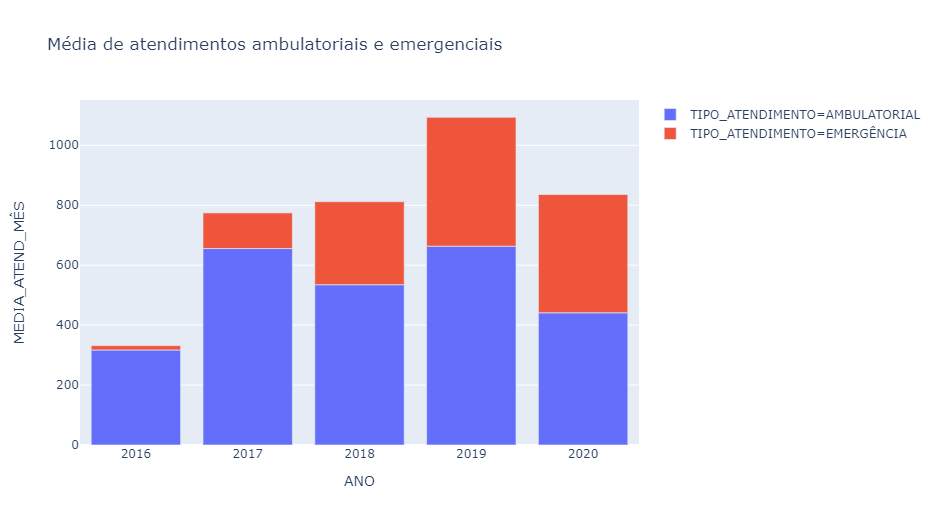

**2.3.1 Quantas internações por CID L20?**

**2.3.2 Qual o custo das AIH associadas ao CID L20 em um ano?**


In [99]:
internacao_custos = df_sih_l20[df_sih_l20.DIAG_PRINC.str[:3] == 'L20'].groupby('ANO_CMPT').agg(
    INTERNACOES = pd.NamedAgg('N_AIH', 'count'),
    CUSTO_TOTAL = pd.NamedAgg('VAL_TOT', 'sum')
)

internacao_custos

,INTERNACOES,CUSTO_TOTAL
ANO_CMPT,,
2016,989,301298.52
2017,950,296785.36
2018,1068,328294.74
2019,1029,326203.54
2020,720,286286.31


In [ ]:
px.bar(internacao_custos.reset_index(), x='ANO_CMPT', y='CUSTO_TOTAL', title='Qual o custo das AIH associadas ao CID L20 em um ano?')

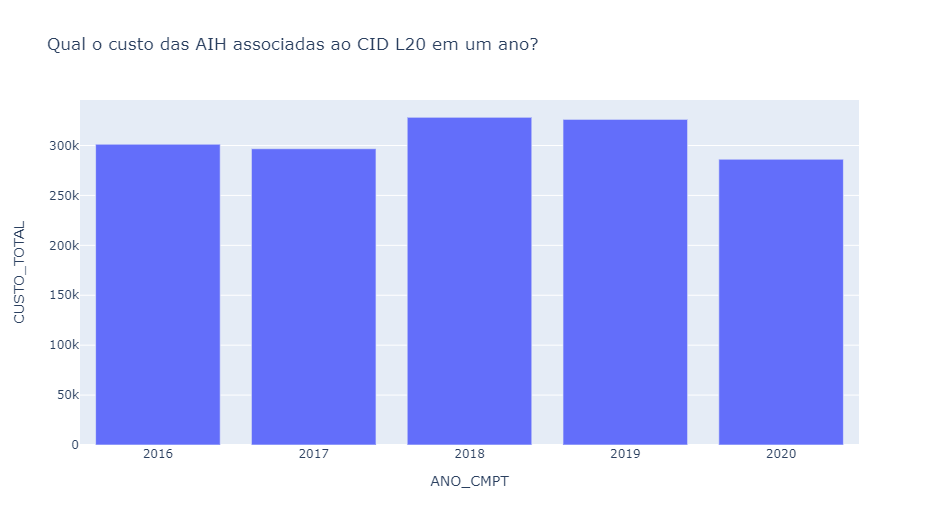

In [ ]:
px.bar(internacao_custos.reset_index(), x='ANO_CMPT', y='INTERNACOES', title='Quantas internações associadas ao CID L20 em um ano?')

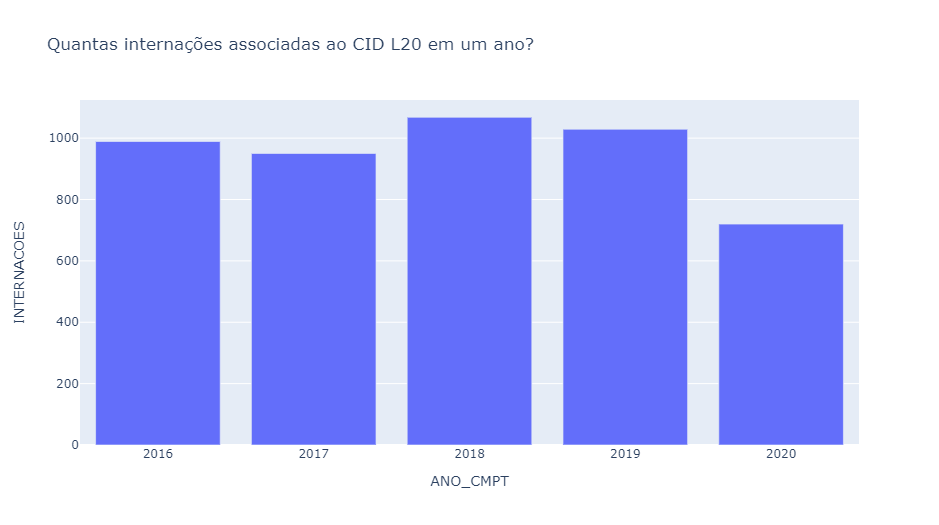

**2.3.3 Qual o tempo médio de internação dos pacientes com diagnóstico L20? (Dados de AIH)**

In [102]:
tempo_internacao = df_sih_l20[df_sih_l20.DIAG_PRINC.str[:3] == 'L20'].groupby('ANO_CMPT').agg(
    MEDIA_DIAS_INTERNACAO=pd.NamedAgg('QT_DIARIAS', 'mean')
)

tempo_internacao

,MEDIA_DIAS_INTERNACAO
ANO_CMPT,
2016,4.723964
2017,4.550526
2018,4.520599
2019,4.705539
2020,4.455556


In [ ]:
px.bar(tempo_internacao.reset_index(), x='ANO_CMPT', y='MEDIA_DIAS_INTERNACAO', title='Qual o tempo médio de dias de internação de pacientes com CID L20?')

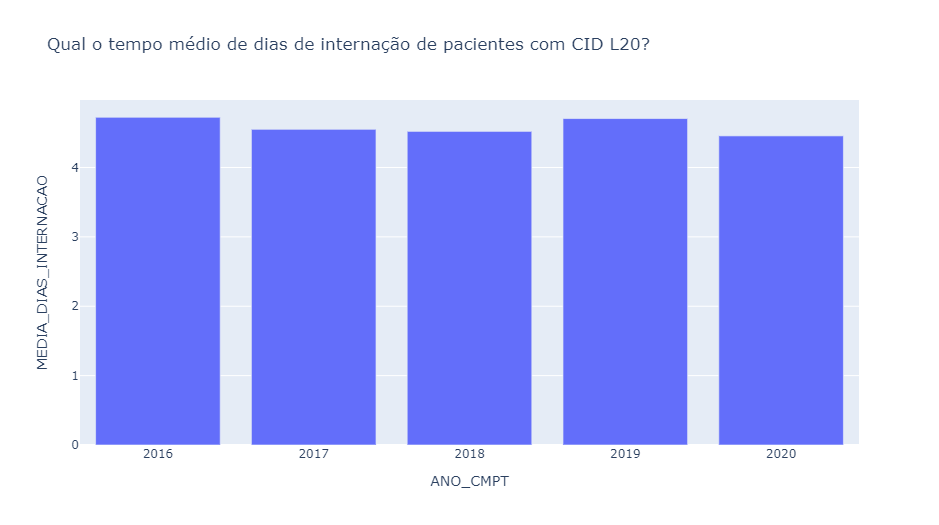

**2.4 Quantos, qual o custo e quais mais comuns procedimentos de alta complexidade realizados por CID L20? (Dados da apac)**

Na base de dados SIA de produção ambulatorial, existem apenas duas APACS relacionadas ao CID L20. É essas duas APACS apontam o L20 como causa associada, não como causa primária. De qualquer maneira, essa é a análise relação dos procedimentos e custos dessas APACS:


In [104]:
df_sia_l20[df_sia_l20.DOC.str.contains('APAC')].groupby(['PA_AUTORIZ', 'PA_PROC_ID']).agg(
    CID_PRIM=pd.NamedAgg('PA_CIDPRI', 'first'),
    CID_SEC=('PA_CIDSEC', 'first'),
    CID_ASSOC=('PA_CIDCAS', 'first'),
    QUANTIDADE=pd.NamedAgg('PA_QTDAPR', 'sum'),
    VALOR_TOTAL=pd.NamedAgg('PA_VALAPR', 'sum')
).reset_index().join(df_proc, on='PA_PROC_ID').set_index(['PA_AUTORIZ', 'PA_PROC_ID'])

CID_PRIM  ...                                    NO_PROCEDIMENTO
PA_AUTORIZ    PA_PROC_ID           ...                                                   
3119232723520 0202010023     0000  ...     DETERMINACAO DE CAPACIDADE DE FIXACAO DO FERRO
              0202010210     0000  ...                                  DOSAGEM DE CALCIO
              0202010279     0000  ...                          DOSAGEM DE COLESTEROL HDL
              0202010287     0000  ...                          DOSAGEM DE COLESTEROL LDL
              0202010295     0000  ...                        DOSAGEM DE COLESTEROL TOTAL
              0202010317     0000  ...                              DOSAGEM DE CREATININA
              0202010384     0000  ...                               DOSAGEM DE FERRITINA
              0202010392     0000  ...                            DOSAGEM DE FERRO SERICO
              0202010422     0000  ...                      DOSAGEM DE FOSFATASE ALCALINA
              0202010430     0000  ...                                 DOSAGEM DE FOSFORO
              0202010473     0000  ...                                 DOSAGEM DE GLICOSE
              0202010600     0000  ...                                DOSAGEM DE POTASSIO
              0202010627     0000  ...              DOSAGEM DE PROTEINAS TOTAIS E FRACOES
              0202010635     0000  ...                                   DOSAGEM DE SODIO
              0202010651     0000  ...   DOSAGEM DE TRANSAMINASE GLUTAMICO-PIRUVICA (TGP)
              0202010678     0000  ...                          DOSAGEM DE TRIGLICERIDEOS
              0202010694     0000  ...                                   DOSAGEM DE UREIA
              0202010767     0000  ...                    DOSAGEM DE 25 HIDROXIVITAMINA D
              0202020380     0000  ...                                 HEMOGRAMA COMPLETO
              0202030300     0000  ...  PESQUISA DE ANTICORPOS ANTI-HIV-1 + HIV-2 (ELISA)
              0202030636     0000  ...  PESQUISA DE ANTICORPOS CONTRA ANTIGENO DE SUPE...
              0202030679     0000  ...  PESQUISA DE ANTICORPOS CONTRA O VIRUS DA HEPAT...
              0202030784     0000  ...  PESQUISA DE ANTICORPOS IGG E IGM CONTRA ANTIGE...
              0202030970     0000  ...  PESQUISA DE ANTIGENO DE SUPERFICIE DO VIRUS DA...
              0202060250     0000  ...         DOSAGEM DE HORMONIO TIREOESTIMULANTE (TSH)
              0202060276     0000  ...                            DOSAGEM DE PARATORMONIO
              0202070085     0000  ...                                DOSAGEM DE ALUMINIO
              0305010093     0000  ...  HEMODIÁLISE (MÁXIMO 1 SESSÃO POR SEMANA - EXCE...
              0305010107     0000  ...          HEMODIÁLISE (MÁXIMO 3 SESSÕES POR SEMANA)
3517251336478 0211020010     I209  ...                               CATETERISMO CARDIACO

[30 rows x 6 columns]

**2.5 Comparação de CID L20 versus outros CIDs da dermatologia de doença crônica (L40, psoríase por exemplo) e de doenças mais comuns (L70 Acne e L81.1 Melasma). Qual o número médio de consulta por paciente ambulatorial e emergencial de um e outro diagnóstico?**

A Dermatite Atópica representa apenas 0,87% de todos os atendimentos ambulatoriais e de emergência relacionados à doenças dermatológicos.

In [105]:
df_l20_proportion.head(30)

,PA_CIDPRI,NO_CID,PERCENT
L70,1055054,Acne,19.88
L40,935959,Psoríase,17.63
L02,836539,Abscesso cutâneo furunculo e antraz,15.76
L98,723484,Outras afecções da pele e do tecido subcutâneo...,13.63
L72,256976,Cistos foliculares da pele e do tecido subcutâneo,4.84
L80,165893,Vitiligo,3.13
L97,156057,Úlcera dos membros inferiores não classificada...,2.94
L08,106308,Outras infecções localizadas da pele e do teci...,2.00
L93,85381,Lupus eritematoso,1.61
L60,76943,Afecções das unhas,1.45


In [ ]:
px.bar(df_l20_proportion.head(17), x='PERCENT', y='NO_CID', title='Proporção de dermatite atópica dentre doenças dermatológicas', orientation='h')

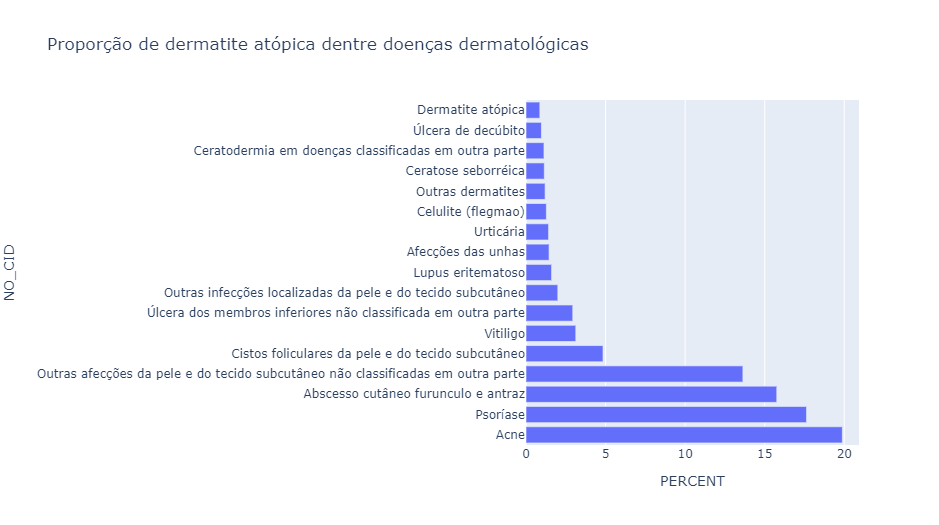

**2.6 Quais as regiões que mais utilizam recursos de alto custo (medicamentos sistêmicos e fototerapias), qual a faixa etaria que mais utiliza, qual sexo, quais cidades mais utilizam, tem relação com áreas mais urbanizadas? (Dados de
LME, AIH e SIA)**

Não há na base de dados completa **nenhum registro** de utilização do procedimento de FOTOTERAPIA com código CID primário ou secundário da DERMATITE ATÓPICA (L20). Esses são os CIDs que recebem procedimentos de fototerapia:

In [107]:
fototerapia = df_pt.join(df_cid_short, on='CID')

fototerapia

,CID,COUNT,PERCENT,NO_CID
0,L40,243404,40.3,Psoríase
1,L80,158888,26.3,Vitiligo
2,C84,142826,23.6,Linfomas de células t cutâneas e periféricas
3,L86,59592,9.9,Ceratodermia em doenças classificadas em outra...


In [ ]:
px.bar(df_pt.join(df_cid_short, on='CID'), x='COUNT', y='NO_CID', title='Doenças que recebem procedimentos de fototerapia',orientation='h')

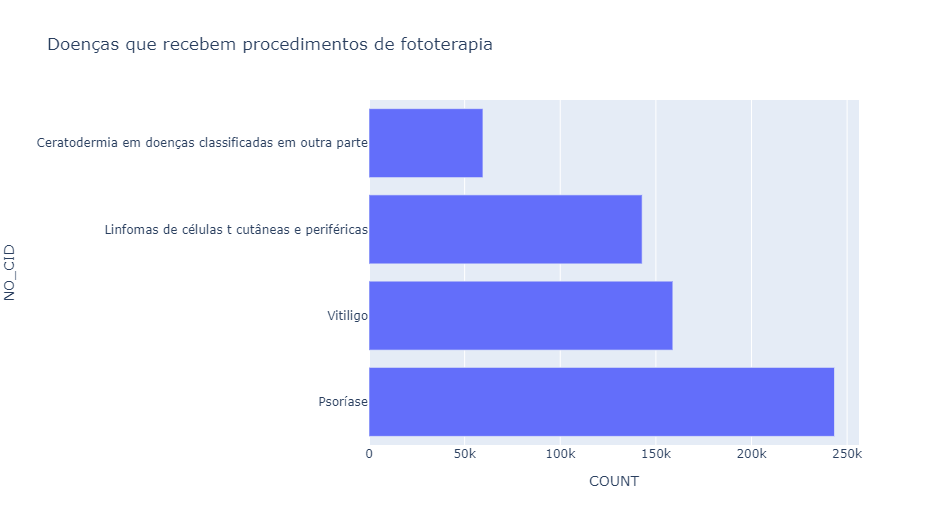

No entanto, há alguns registros (97 apenas) de utilização ciclosporina para o CID L20. A seguir, as faixas etárias que mais recebem a medicação.

In [109]:
medicamento_etaria=df[df.PA_PROC_ID.isin(ciclosporina)].groupby('FAIXA_ETARIA').agg(
    NUM_PROCEDIMENTOS=pd.NamedAgg('PA_PROC_ID', 'count')
)

In [ ]:
px.bar(medicamento_etaria.reset_index(),x='FAIXA_ETARIA',y='NUM_PROCEDIMENTOS',title='Qual faixa etaria mais utiliza ciclosporina para o CID L20?')

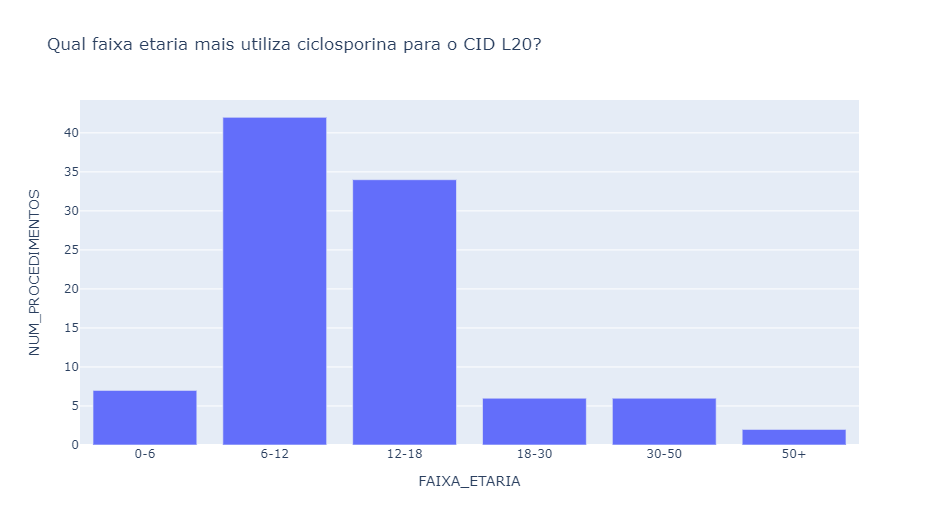

Todos os registros de **ciclosporina** dispensada aconteceram no estado de São Paulo.

In [111]:
df[df.PA_PROC_ID.isin(ciclosporina)].groupby('UF').agg(
    NUM_PROCEDIMENTOS=pd.NamedAgg('PA_PROC_ID', 'count')
)

,NUM_PROCEDIMENTOS
UF,
SP,97


In [112]:
df_map = df.loc[:, ['SEVERIDADE', 'PACIENTE', 'PA_CODUNI']].join(
    df_cnes.set_index('CO_CNES')[['NU_LATITUDE', 'NU_LONGITUDE']], on='PA_CODUNI'
).groupby(
    ['SEVERIDADE', 'PA_CODUNI']
).agg(
    NUM_PACIENTES=pd.NamedAgg('PACIENTE', 'nunique'),
    NU_LATITUDE=pd.NamedAgg('NU_LATITUDE', 'first'),
    NU_LONGITUDE=pd.NamedAgg('NU_LONGITUDE', 'first')
).sort_values(
    ['SEVERIDADE', 'NUM_PACIENTES'], ascending=False
)

# Drop register with missing LAT and LON
df_map.dropna(inplace=True)

# Replace ',' for '.'
df_map['NU_LATITUDE'] = df_map.NU_LATITUDE.str.replace(',', '.')
df_map['NU_LONGITUDE'] = df_map.NU_LONGITUDE.str.replace(',', '.')

# Drop a row with only a '-'
df_map.drop(labels='2165155', level=1, inplace=True)

# Convert LAT and LON to 'float'
df_map['NU_LATITUDE'] = df_map['NU_LATITUDE'].astype('float')
df_map['NU_LONGITUDE'] = df_map['NU_LONGITUDE'].astype('float')


In [ ]:
fig = px.scatter_mapbox(df_map.reset_index(),
                        lat='NU_LATITUDE',
                        lon='NU_LONGITUDE',
                        color='SEVERIDADE',
                        size='NUM_PACIENTES',
                        size_max=20,
                        zoom=2.5,
                        mapbox_style='open-street-map',
                        title='Concentração de casos de Dermatite Atópica por localidade')
fig.show()

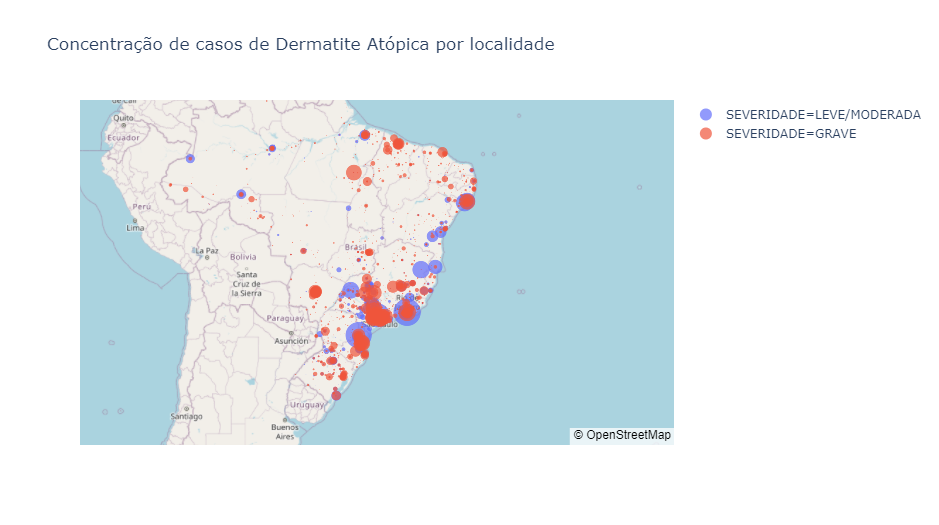

**2.7 Qual o custo de um paciente moderado a grave versus leve? (Não temos dados para falar do custo do paciente leve, o que foi prescrito, quantas consultas, etc). Podemos apenas inferir o valor de pacientes de DA moderados a grave associados a internações, tratamentos e exames de alta complexidade.**

In [ ]:
custos = df.groupby(['SEVERIDADE', 'PACIENTE']).agg(
    VALOR=pd.NamedAgg('PA_VALAPR', 'sum')
).reset_index().groupby('SEVERIDADE').agg(
    VALOR_MEDIO=pd.NamedAgg('VALOR', 'mean')
)

px.bar(custos.reset_index(), x='SEVERIDADE', y='VALOR_MEDIO', title='Qual o custo de um paciente moderado a grave versus leve?')

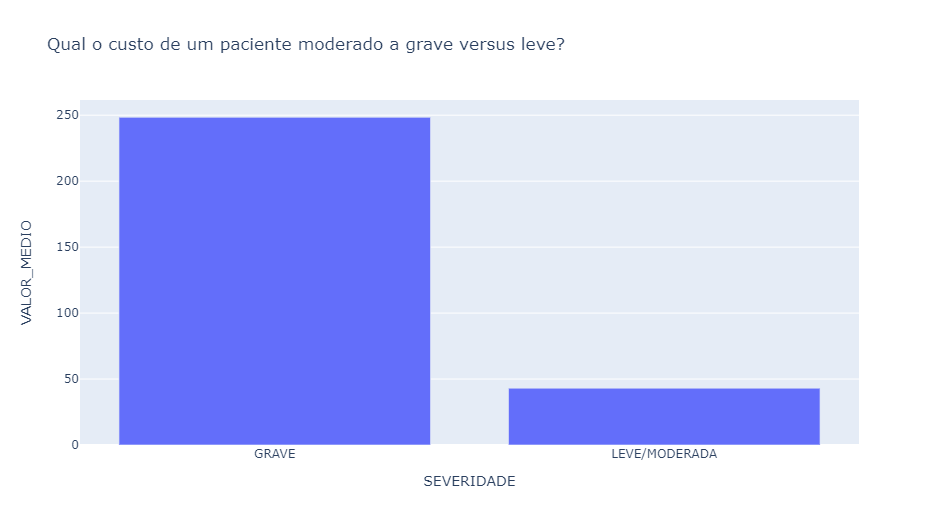

###**PERGUNTA 3**###
**Comparação com outros CIDs de doenças crônicas: L40 (psoríase) e L73.2
(hidradenite supurativa)**

3.1 Quantos benefícios solicitados e concedidos comparativamente entre as doenças?<br>
3.2 Qual a faixa etária que mais solicita em cada uma das doenças.<br>
3.3 Quais tipos de benefícios mais solicitados e mais concedidos

**As respostas para essas três perguntas se encontram no notebook auxiliar 'dermatite_inss.ipynb' e não foram adicionadas aqui porque a memória RAM disponível no Google Colab não permitiria o carregamento das tabelas de benefícios concedidos e indeferidos pelo INSS**.



**3.4 Qual seria o DALY para dermatite atópica? = Perda de dias saudáveis devido à doença**

**D**ISABILITY **A**DJUSTED **L**IFE **Y**EARS ou **DALY**<br><br>
**DALY = MORBIDITY + MORTALITY** ou<br>
**DALY = YLD + YLL**, onde:<br>
YLD = Years Lived with Disability<br>
YLL = Years of Life Lost<br><br>
**YLD = DW x P**, onde:<br>
DW = disability weight of the condition<br>
P = prevalent cases in the population (de acordo com o último relatório técnico da OMS)<br><br>
**YLL = N x L**, onde:<br>
N = number of deaths due to condition<br>
L = standard life expectancy at the age of death<br>




**Disability Weights** retirados de 'Global Health Data Exchange' em http://ghdx.healthdata.org/record/ihme-data/gbd-2019-disability-weights

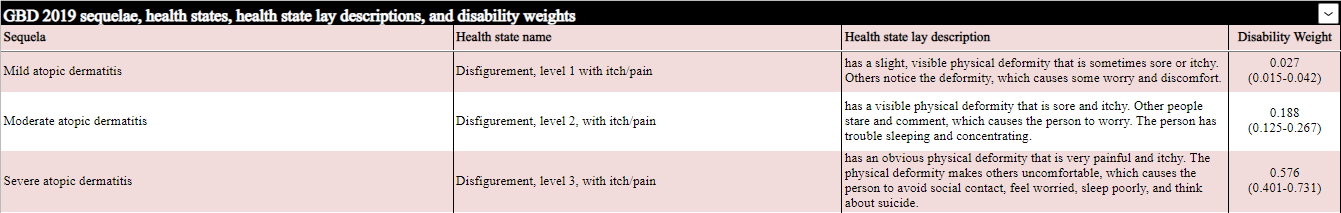

In [115]:
# Disability weights (considering lower bounds)
dw = {
    'GRAVE': 0.576,
    'LEVE/MODERADA': 0.188
}

In [116]:
# Life expectancy retrieved from "Table 2.1 Standard loss functions used in Global Burden of Disease studies and 
# for WHO Global Health Estimates" found at:
# https://cdn.who.int/media/docs/default-source/gho-documents/global-health-estimates/ghe2019_daly-methods.pdf?sfvrsn=31b25009_7

le = {
    -1: 89.55,
    0: 87.07,
    4: 82.58,
    9: 77.58,
    14: 72.60,
    19: 67.62,
    24: 62.66,
    29: 57.71,
    34: 52.76,
    39: 47.83,
    44: 42.94,
    49: 38.10,
    54: 33.33,
    59: 28.66,
    64: 24.12,
    69: 19.76,
    74: 15.65,
    79: 11.96,
    84: 7.05,
    109: 0 
}


In [117]:
# Create data frame
df_daly = df.groupby(['ANO', 'PACIENTE']).agg(
    SEVERIDADE=pd.NamedAgg('SEVERIDADE', 'first'),
    IDADE=pd.NamedAgg('PA_IDADE', 'min'),
    MORTE=pd.NamedAgg('MORTE', 'max')
)

# Add disability weights accoding to severity
df_daly['DW'] = df_daly['SEVERIDADE'].map(dw)

# Add life expectancy column
df_daly['LE'] = pd.cut(df_daly.IDADE, bins=list(le.keys()), labels=list(le.values())[:-1], include_lowest=True).astype('float')

# Calculate YLL and add as a column
df_daly['YLL'] = df_daly.MORTE * df_daly.LE



In [118]:
# Aggregate DW calculating YLD (prevalent cases x DW)
df_daly = df_daly.groupby('ANO').agg(
    YLD=pd.NamedAgg('DW', 'sum'),
    YLL=pd.NamedAgg('YLL', 'sum')
)

# Add DALY column
df_daly['DALY'] = round(df_daly.YLD + df_daly.YLL, 2)




**É importante lembrar que esses valores de DALY são estimados uma vez que dependem da informação de prevalência de casos, que por sua vez dependem da chave única de identificação de paciente, que foi artificialmente introduzida nas bases de dados**<br>

Outra observação interessante é que o *Global Burden of Disease Study 2019 (GBD 2019)* estima um **DALY de 737.092 para todas as doenças de pele no Brasil**. Se considerarmos que a nossa análise determina que a Dermatite Atópica representa 0,87% de todos os registros de produção ambulatorial do SUS referentes à doencas de pele, se aplicarmos essa proporção na estimativa do GBD 2019 (0,87% x 737.092), teríamos um DALY para Dermatite Atópica de **6.412**. Em termos de grandeza, esse resultado parece consistente com os números de DALY que calculamos nessa análise a partir dos dados abertos do SUS e que estão logo abaixo:

In [119]:
df_daly

,YLD,YLL,DALY
ANO,,,
2016,876.320,112.25,988.57
2017,1247.964,38.10,1286.06
2018,1524.184,176.54,1700.72
2019,2084.048,127.77,2211.82
2020,1874.180,0.00,1874.18


In [ ]:
px.bar(df_daly.reset_index(),x='ANO',y='DALY',title='Qual seria o DALY para dermatite atópica?')

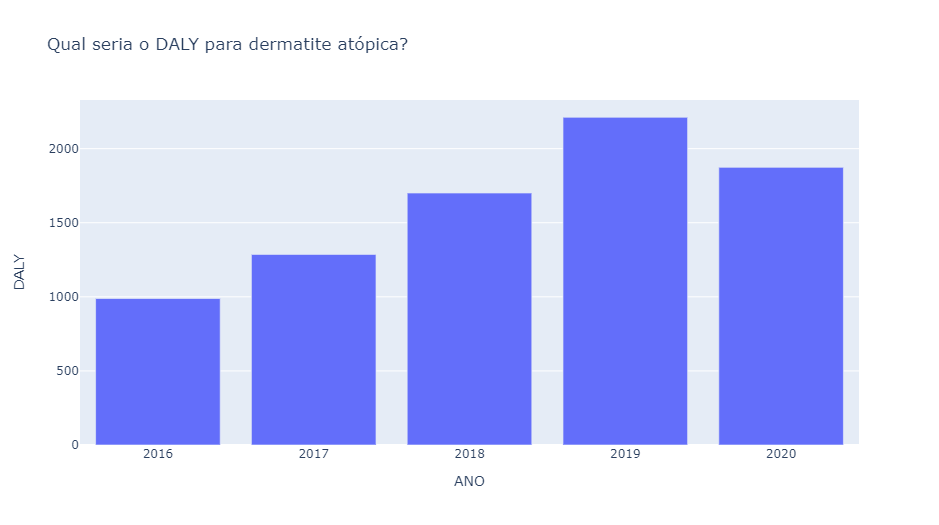